In [1]:
from IPython.display import clear_output, Audio
%pip install pytorch-ignite
clear_output()

In [2]:
import os
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchaudio
from torchaudio.utils import download_asset
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tf
import torch.nn.functional as fu
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as sc

REPRODUCIBILITY AND GPU ACCESS

In [3]:
# https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [4]:
#Checking GPU access
print(f"We have {'' if torch.cuda.is_available() else 'not'}access to a GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    print(device)

We have access to a GPU
0
1
Tesla P100-PCIE-16GB
cuda


MOUNTING DRIVE

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DATA VISUALIZATION AND PREPROCESSING


In [6]:
plt.rcParams["figure.figsize"] = (12,15)

In [7]:
#Normalization function between -1 and 1
def normalize(signal):
  return 2*(signal-torch.min(signal))/(torch.max(signal)-torch.min(signal))-1

torch.Size([1, 52664]) torch.Size([1, 52664])


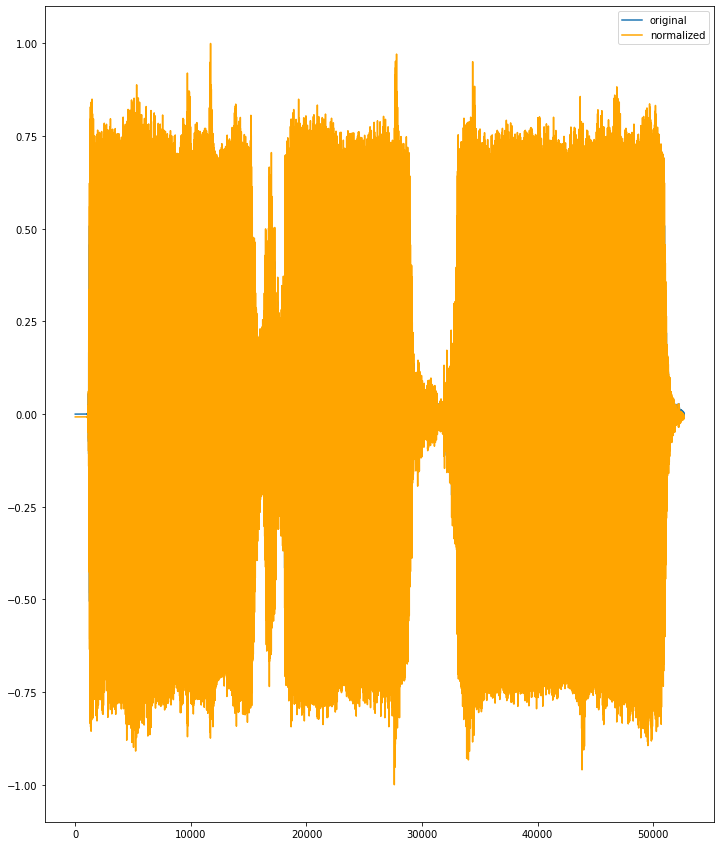

In [8]:
#Visualizing one audio waveform and reproducing it
s, sr = torchaudio.load('/content/drive/MyDrive/ASVP-ESD-Update/Audio/actor_21/03-01-08-02-98-21-02-02-02.wav')
print(s.shape, normalize(s).shape)

fig, ax = plt.subplots()
ax.plot(s.squeeze(), label = 'original')
ax.plot(normalize(s).squeeze(), label = 'normalized', color = 'orange')
ax.legend()

Audio(s, rate = sr)

DATAFRAME

In [9]:
#Creating a Dataframe with all the audios and increasing the number of datat by slicing 
torch.set_printoptions(profile = 'full')
CUT = 3 #cut files in 3 seconds delete the remaining
_emotions = {'01': 0, '02': 1, '03': 2, '04': 3, '05': 4, '06': 5, '07': 6, '08': 7, '09': 8, '10': 9, '11': 10, '12': 11, '13': 12} 
df = pd.DataFrame()
root = '/content/drive/MyDrive/ASVP-ESD-Update/Audio'
#LEN = 2000 #attuale dim del dataset
#index = 0
#while index < LEN:
for root, dirs, files in os.walk(root):
  #if "Audio" in root: 
  for f in files:
    identifiers = f[:-4].split('-') #crea lista per raccogliere elementi separati dal "-"
    emotion = identifiers[2]
    sign, sr = torchaudio.load(os.path.join(root,f), num_frames = CUT*sr) #load only the first 3 seconds 
    samples = sign.size(-1) #lunghezza in frames/samples
    seconds = samples/sr    #lunghezza segnale in secondi

    #normalize audio signal between -1 and 1
    sign = normalize(sign)

    if seconds == CUT:
      data = [seconds, emotion, sign, f]
      df = df.append(pd.Series(data, index = ["seconds","emotion","signal","filename"]), ignore_index=True)
    elif seconds < CUT:
      sign = fu.pad(sign,(0, CUT*sr-samples))
      data = [sign.size(-1)/sr, emotion, sign, f]
      df = df.append(pd.Series(data, index = ["seconds","emotion","signal","filename"]), ignore_index=True)
  #index = index + 1
  
df['emotion'] = df['emotion'].map(_emotions)   
df

seconds  emotion                                             signal  \
0         3.0       12  [[tensor(0.0873), tensor(0.0873), tensor(0.087...   
1         3.0       12  [[tensor(-0.0675), tensor(-0.0674), tensor(-0....   
2         3.0       12  [[tensor(0.4029), tensor(0.2464), tensor(0.209...   
3         3.0       12  [[tensor(-0.0308), tensor(-0.0308), tensor(-0....   
4         3.0       12  [[tensor(-0.0135), tensor(-0.0135), tensor(-0....   
...       ...      ...                                                ...   
4825      3.0        2  [[tensor(-0.0608), tensor(-0.0608), tensor(-0....   
4826      3.0        2  [[tensor(-0.0293), tensor(-0.0293), tensor(-0....   
4827      3.0        2  [[tensor(-0.0552), tensor(-0.0552), tensor(-0....   
4828      3.0        3  [[tensor(-0.1105), tensor(-0.1105), tensor(-0....   
4829      3.0        2  [[tensor(0.0690), tensor(0.0690), tensor(0.069...   

                                filename  
0     03-02-13-01-02-111-02-02-02-13.wav  
1     03-02-13-01-01-127-02-02-02-13.wav  
2     03-02-13-01-03-107-02-02-02-13.wav  
3     03-02-13-01-01-116-02-02-02-13.wav  
4     03-02-13-01-02-116-02-02-02-13.wav  
...                                  ...  
4825   03-02-03-01-03-09-02-03-01-23.wav  
4826      03-01-03-02-16-09-02-03-01.wav  
4827      03-01-03-01-04-09-02-03-01.wav  
4828   03-01-04-01-02-09-02-03-01-77.wav  
4829      03-01-03-01-10-09-02-03-01.wav  

[4830 rows x 4 columns]

In [10]:
#Calcolo percentuale di emozioni nel ds
freq =df['emotion'].value_counts()
print(freq)
class_weights = torch.as_tensor([freq[0]/len(df),freq[1]/len(df),freq[2]/len(df), \
                              freq[3]/len(df),freq[4]/len(df),freq[5]/len(df), \
                              freq[6]/len(df),freq[7]/len(df),freq[8]/len(df), \
                              freq[9]/len(df),freq[10]/len(df),freq[11]/len(df),\
                              freq[12]/len(df)], device = device)
print(class_weights)

2     1001
3      830
1      692
4      687
7      553
5      475
12     171
10      97
11      86
8       86
6       80
0       49
9       23
Name: emotion, dtype: int64
tensor([0.0101, 0.1433, 0.2072, 0.1718, 0.1422, 0.0983, 0.0166, 0.1145, 0.0178,
        0.0048, 0.0201, 0.0178, 0.0354], device='cuda:0', dtype=torch.float64)


MEL-FREQUENCY CEPSTRAL COEFFICIENTS (MFCCs)

In [11]:
n_fft = 1024
win_length = int(sr*64/1000)    #64 ms 
hop_length = int(sr*16/1000)    #16 ms
n_mels = 128
n_mfcc = 40

mfcc_transform = T.MFCC(sample_rate = sr, n_mfcc = n_mfcc, log_mels = True, melkwargs={"n_fft": n_fft,
                                                                             "n_mels": n_mels,
                                                                             "hop_length": hop_length,
                                                                             "mel_scale": "htk",
                                                                             'f_min': 40, #HZ
                                                                             'f_max': 7600})

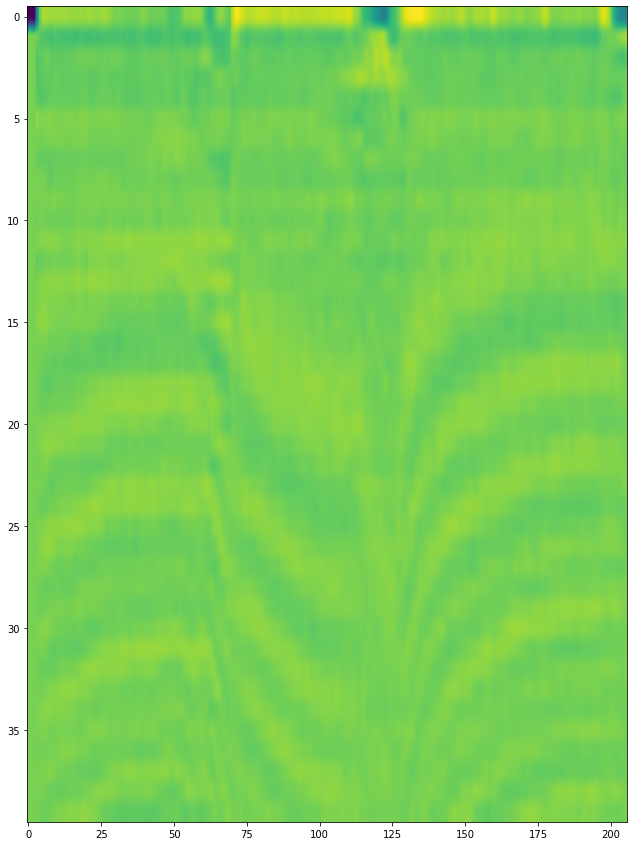

In [12]:
mfcc = mfcc_transform(s)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(mfcc.squeeze())
ax.set_aspect(7)
plt.show()

DATASET 

In [13]:
class ASVPDataset(Dataset): #cambio nome per adattare al dataset ASVP-ESD
    
    def __init__(self, df=None, transform=None):
        self.df = df
        self.transform = tf.Normalize(mean=[0.456],std=[0.224])
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      CUT = 3
      if torch.is_tensor(idx):
          idx = idx.tolist()
      
      waveform = self.df.loc[idx,'signal']
      mfcc = mfcc_transform(waveform).to(device)

      emotion = self.df.loc[idx,'emotion']
      emotion = torch.tensor(emotion, dtype = int, device = device)

      #Applying transformation
      if self.transform:
          mfcc=self.transform(mfcc)
      
      return mfcc, emotion

The image size in the dataset is torch.Size([1, 40, 188]) and the emotion is size torch.Size([])
The emotion of this audio is the 5


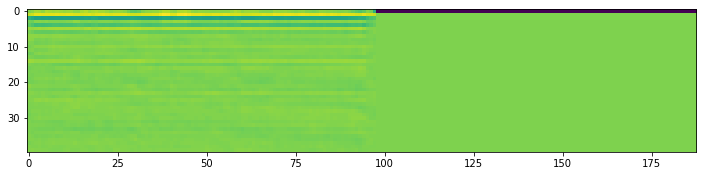

In [14]:
#Initializing the dataset
asvp = ASVPDataset(df)
#Printing a random example to see if everything is correct
example , emotion = random.choice(asvp)
print(f"The image size in the dataset is {example.shape} and the emotion is size {emotion.shape}") #printing the size of the tensors returned by the dataset

#plotting the MFCCs
plt.imshow(example.squeeze().cpu())

print(f"The emotion of this audio is the {emotion}")

TRAIN/VAL SPLIT

In [15]:
#TRAIN TEST SPLIT
train_size = int(0.8 * len(asvp))
test_size = len(asvp) - train_size

#Splitting the dataset in validation (20%) and train (80%)
train_dataset, test_dataset = torch.utils.data.random_split(asvp, [train_size, test_size])

print(f"Lenght of the training dataset is {len(train_dataset)} items")
print(f"Lenght of the validation dataset is {len(test_dataset)} items")
# Shapes of the dataset
print(f"The shape of the first mfcc image in the test dataset is {train_dataset[0][0].shape}")
print(f"The shape of the label emotion of the first audio in the train dataset is {train_dataset[0][1].shape}")
print(f"The shape of the first mfcc image in the validation dataset is {test_dataset[0][0].shape}")
print(f"The shape of the label emotion of the first audio in the validation dataset is {test_dataset[0][1].shape}")


Lenght of the training dataset is 3864 items
Lenght of the validation dataset is 966 items
The shape of the first mfcc image in the test dataset is torch.Size([1, 40, 188])
The shape of the label emotion of the first audio in the train dataset is torch.Size([])
The shape of the first mfcc image in the validation dataset is torch.Size([1, 40, 188])
The shape of the label emotion of the first audio in the validation dataset is torch.Size([])


MODEL

In [16]:
#Function that calculates the correct padding for all the convolutions in the model
def calc_padding(k1,k2,h,w):
  o1 = h
  o2 = w
  s=1
  p1 = (s*(o1-1) + k1-h)//2
  p2 = (s*(o2-1) + k2-w)//2
  return p1, p2

In [17]:
#Calculate the correct padding for all convolutions
h = example.size(1)
w = example.size(2)
print(f"Padding needed for the convolutions in the Parallel Paths are {calc_padding(11,1,h,w),calc_padding(1,9,h,w),calc_padding(3,3,h,w)}")
print(f"Padding needed for the convolution in the Feature Learning is {calc_padding(1,1,h,w)}")

Padding needed for the convolutions in the Parallel Paths are ((5, 0), (0, 4), (1, 1))
Padding needed for the convolution in the Feature Learning is (0, 0)


In [18]:
class ParallelPaths(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_pp1 = nn.Conv2d(padding = calc_padding(11,1,h,w), stride= 1, in_channels=1, out_channels=64,padding_mode= 'replicate', kernel_size=(11,1))
        self.conv_pp2 = nn.Conv2d(padding = calc_padding(1,9,h,w), stride= 1, in_channels=1, out_channels=64,padding_mode= 'replicate', kernel_size=(1,9))
        self.conv_pp3 = nn.Conv2d(padding = calc_padding(3,3,h,w), stride= 1, in_channels=1, out_channels=64,padding_mode= 'replicate', kernel_size=(3,3))
        self.batch_norm_pp = nn.BatchNorm2d(64)
        self.relu_pp = nn.PReLU()
        self.avg = nn.AvgPool2d( kernel_size = 1, stride =1 ) #in the paper kernel_size is 2

    def forward(self, x):
        start=x
        #first path
        x1 = self.conv_pp1(start)
        x1 = self.batch_norm_pp(x1)
        x1 = self.relu_pp(x1)
        x1 = self.avg(x1)
        x1 = x1 + start #added for better gradient propagation
        #second path
        x2 = self.conv_pp2(start)
        x2 = self.batch_norm_pp(x2)
        x2 = self.relu_pp(x2)
        x2 = self.avg(x2)
        x2 = x2 + start
        #third path
        x3 = self.conv_pp3(start)
        x3 = self.batch_norm_pp(x3)
        x3 = self.relu_pp(x3)
        x3 = self.avg(x3)
        x3 = x3 + start
        #concatenate tensor along last dimension
        x = torch.cat((x1,x2,x3),-1) 
        return x

class FeatureExtractor(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_fe1 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=64, out_channels=64,padding_mode= 'replicate', kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe2 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=64, out_channels=96,padding_mode= 'replicate', kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe3 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=96, out_channels=128, padding_mode= 'replicate',kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe4 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=128, out_channels=160,padding_mode= 'replicate', kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe5 = nn.Conv2d(padding = calc_padding(1,1,h,w),in_channels=160, out_channels=320,padding_mode= 'replicate', kernel_size=(1,1), stride=(1,1), bias = False)
        self.relu_fe = nn.PReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(96)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(160)
        self.bn5 = nn.BatchNorm2d(320)
        self.avg2 = nn.AvgPool2d(padding=0 , kernel_size =(1,1), stride =1)
        self.avg1 = nn.AvgPool2d(padding=0 , kernel_size =(2,2), stride =1)

    def forward(self, x):
      
      
      x = self.conv_fe1(x)
      x = self.bn1(x)
      x = self.relu_fe(x)
      x = self.avg2(x)
      #conc1 = x
      
      x = self.conv_fe2(x)
      x = self.bn2(x)
      x = self.relu_fe(x)
      x = self.avg2(x)
      #conc2 = x
      
      x = self.conv_fe3(x)
      x = self.bn3(x)
      x = self.relu_fe(x)
      x = self.avg2(x)
    
      x = self.conv_fe4(x)
      x = self.bn4(x)
      x = self.relu_fe(x)
      x = self.avg2(x)
      #x = torch.cat((conc1,conc2),1)
    
      x = self.conv_fe5(x)
      x = self.bn5(x)
      x = self.relu_fe(x)
      x = x.mean([2,3]) #global average pooling
      
      return x

class CNN(nn.Module):
    """
    Implementation of the CNN as described in the paper.
    """
    def __init__(self):
        super().__init__()

        self.pp = ParallelPaths()
        self.fe = FeatureExtractor()
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features = 320, out_features = 13)


    def forward(self, x):
      x = self.pp(x)
      x = self.fe(x)
      x = self.dropout(x)
      x = self.fc(x)
      #x = self.softmax(x) #because in the pytorch cross entropy the softmax is already done 

      return x

In [19]:
from torchsummary import summary
#Initialize the Convolutional Neural Network
cnn_net = CNN()
cnn_net = cnn_net.to(device)
#Visualize it by sending a random input which as the same shape of the data
summary(cnn_net,(1,h,w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 40, 188]             768
       BatchNorm2d-2          [-1, 64, 40, 188]             128
             PReLU-3          [-1, 64, 40, 188]               1
         AvgPool2d-4          [-1, 64, 40, 188]               0
            Conv2d-5          [-1, 64, 40, 188]             640
       BatchNorm2d-6          [-1, 64, 40, 188]             128
             PReLU-7          [-1, 64, 40, 188]               1
         AvgPool2d-8          [-1, 64, 40, 188]               0
            Conv2d-9          [-1, 64, 40, 188]             640
      BatchNorm2d-10          [-1, 64, 40, 188]             128
            PReLU-11          [-1, 64, 40, 188]               1
        AvgPool2d-12          [-1, 64, 40, 188]               0
    ParallelPaths-13          [-1, 64, 40, 564]               0
           Conv2d-14          [-1, 64, 

DATALOADER

The valued stored in the tensor of the label of the first signal is 10
The size of the batch of images is torch.Size([32, 1, 40, 188])
The size of the batch of labels is torch.Size([32])


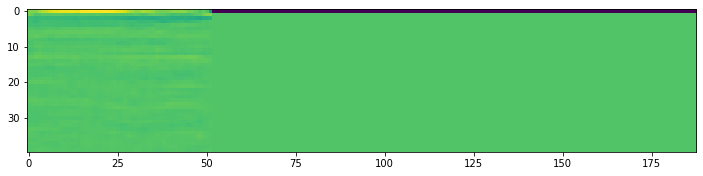

In [20]:
#DATALOADER
#Initializing the Dataloader and setting the size of each batch
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
validation_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True)

#Checking that everything is fine in the Dataloader
mfcc, train_labels = next(iter(train_dataloader)) #iterate in the Dataloader
#Visualize the first input image mfcc 
plt.imshow(mfcc[0].squeeze().cpu())
#Print first label emotion
print(f"The valued stored in the tensor of the label of the first signal is {train_labels[0]}")
#Print shapes of data inside Dataloader
print(f"The size of the batch of images is {mfcc.size()}")
print(f"The size of the batch of labels is {train_labels.size()}")

LOSS

In [21]:
###FOCAL LOSS
# https://github.com/VSainteuf/pytorch-psetae/blob/master/learning/focal_loss.py
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = fu.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

METRICS AND IGNITE

In [22]:
from ignite.engine import Engine,create_supervised_evaluator,Events,create_supervised_trainer
from ignite.contrib.handlers import ProgressBar
from ignite.handlers import ModelCheckpoint, global_step_from_engine
from glob import glob
from ignite.metrics import Precision, Recall, Loss

In [23]:
#TRAINING with ignite library
LR = 1e-4 #learning rate (5e-5)

#METRICS
#In the paper they use 3 metrics UA, WA, F1
metric0 = Precision(average=True)       #UA
metric1 = Precision(average='weighted') #WA
precision = Precision(average=False)
recall = Recall(average=False)
F1 = ((precision * recall * 2 / (precision + recall)).mean())*100 #F1

#LOSS CRITERIONS 
#In the paper they try 2 criterions CE and F-Loss
criterion = torch.nn.CrossEntropyLoss()
criterion2 = FocalLoss(gamma=2, alpha = class_weights) #in the paper they don't use alpha

#OPTIMIZER
optimizer = optim.Adam(cnn_net.parameters(), lr = LR, weight_decay=1e-6)

#SCHEDULER
scheduler = sc.ExponentialLR(optimizer, gamma = 0.9) #previously was 0.86
#scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=int(len(train_dataloader)), epochs = 300 , anneal_strategy='linear')

# Accuracy and loss metrics are defined
val_metrics = {
  "accuracy": metric0*100,
  "weighted acc": metric1*100,
  "ce_loss": Loss(criterion),
  "focal_loss": Loss(criterion2) }

TRAINING

In [24]:
#Training/Validation functions, events and handlers are adapted from the IGNITE library documentation
trainer = create_supervised_trainer(cnn_net, optimizer, criterion2, device)
train_evaluator = create_supervised_evaluator(cnn_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(cnn_net, metrics=val_metrics, device=device)

# Attach metrics to the evaluators
for name, metric in val_metrics.items():
    metric.attach(train_evaluator, name)

for name, metric in val_metrics.items():
    metric.attach(val_evaluator, name)

#attach F1 to evaluators
F1.attach(train_evaluator, "F1_score")
F1.attach(val_evaluator, "F1_score")

In [25]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_dataloader)
    metrics = train_evaluator.state.metrics
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f}% Avg F1: {metrics['F1_score']:.2f}% Avg weig accuracy: {metrics['weighted acc']:.2f}%  Avg Focal loss: {metrics['focal_loss']:.2f}  Avg CE loss: {metrics['ce_loss']:.2f}")


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(validation_loader)
    metrics = val_evaluator.state.metrics
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f}% Avg F1: {metrics['F1_score']:.2f}% Avg weig accuracy: {metrics['weighted acc']:.2f}%  Avg Focal loss: {metrics['focal_loss']:.2f}  Avg CE loss: {metrics['ce_loss']:.2f}")

In [26]:
ProgressBar().attach(trainer, output_transform=lambda x: {'batch loss': x})

In [27]:
# Score function to select relevant metric, here f1
def score_function(engine):
    return engine.state.metrics["weighted acc"]

# Checkpoint to store n_saved best models wrt score function
model_checkpoint = ModelCheckpoint(
    "SER",
    n_saved=1,
    filename_prefix="best",
    score_function=score_function,
    score_name="weighted acc",
    global_step_transform=global_step_from_engine(trainer),
)
  
# Save the model (if relevant) every epoch completed of evaluator
val_evaluator.add_event_handler(Events.COMPLETED, model_checkpoint, {"model": cnn_net});

In [28]:
trainer.run(train_dataloader, max_epochs=300)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1/120]   1%|           [00:00<?]

Training Results - Epoch[1] Avg accuracy: 17.87% Avg F1: nan% Avg weig accuracy: 31.25%  Avg Focal loss: 0.16  Avg CE loss: 1.94
Validation Results - Epoch[1] Avg accuracy: 20.01% Avg F1: nan% Avg weig accuracy: 33.65%  Avg Focal loss: 0.16  Avg CE loss: 1.95


[1/120]   1%|           [00:00<?]

Training Results - Epoch[2] Avg accuracy: 22.44% Avg F1: nan% Avg weig accuracy: 40.29%  Avg Focal loss: 0.14  Avg CE loss: 1.83
Validation Results - Epoch[2] Avg accuracy: 24.22% Avg F1: nan% Avg weig accuracy: 42.40%  Avg Focal loss: 0.13  Avg CE loss: 1.85


[1/120]   1%|           [00:00<?]

Training Results - Epoch[3] Avg accuracy: 25.52% Avg F1: nan% Avg weig accuracy: 44.98%  Avg Focal loss: 0.13  Avg CE loss: 1.80
Validation Results - Epoch[3] Avg accuracy: 28.32% Avg F1: nan% Avg weig accuracy: 49.22%  Avg Focal loss: 0.13  Avg CE loss: 1.83


[1/120]   1%|           [00:00<?]

Training Results - Epoch[4] Avg accuracy: 22.97% Avg F1: nan% Avg weig accuracy: 42.37%  Avg Focal loss: 0.12  Avg CE loss: 1.75
Validation Results - Epoch[4] Avg accuracy: 20.72% Avg F1: nan% Avg weig accuracy: 37.68%  Avg Focal loss: 0.12  Avg CE loss: 1.78


[1/120]   1%|           [00:00<?]

Training Results - Epoch[5] Avg accuracy: 25.75% Avg F1: nan% Avg weig accuracy: 46.13%  Avg Focal loss: 0.11  Avg CE loss: 1.74
Validation Results - Epoch[5] Avg accuracy: 26.94% Avg F1: nan% Avg weig accuracy: 48.06%  Avg Focal loss: 0.11  Avg CE loss: 1.78


[1/120]   1%|           [00:00<?]

Training Results - Epoch[6] Avg accuracy: 26.47% Avg F1: nan% Avg weig accuracy: 47.09%  Avg Focal loss: 0.11  Avg CE loss: 1.74
Validation Results - Epoch[6] Avg accuracy: 29.34% Avg F1: nan% Avg weig accuracy: 51.22%  Avg Focal loss: 0.11  Avg CE loss: 1.79


[1/120]   1%|           [00:00<?]

Training Results - Epoch[7] Avg accuracy: 24.57% Avg F1: nan% Avg weig accuracy: 45.53%  Avg Focal loss: 0.11  Avg CE loss: 1.68
Validation Results - Epoch[7] Avg accuracy: 24.16% Avg F1: nan% Avg weig accuracy: 44.15%  Avg Focal loss: 0.11  Avg CE loss: 1.73


[1/120]   1%|           [00:00<?]

Training Results - Epoch[8] Avg accuracy: 26.37% Avg F1: nan% Avg weig accuracy: 47.59%  Avg Focal loss: 0.11  Avg CE loss: 1.67
Validation Results - Epoch[8] Avg accuracy: 26.89% Avg F1: nan% Avg weig accuracy: 47.61%  Avg Focal loss: 0.11  Avg CE loss: 1.73


[1/120]   1%|           [00:00<?]

Training Results - Epoch[9] Avg accuracy: 25.60% Avg F1: nan% Avg weig accuracy: 47.37%  Avg Focal loss: 0.10  Avg CE loss: 1.64
Validation Results - Epoch[9] Avg accuracy: 25.93% Avg F1: nan% Avg weig accuracy: 47.10%  Avg Focal loss: 0.10  Avg CE loss: 1.69


[1/120]   1%|           [00:00<?]

Training Results - Epoch[10] Avg accuracy: 25.90% Avg F1: nan% Avg weig accuracy: 48.62%  Avg Focal loss: 0.11  Avg CE loss: 1.64
Validation Results - Epoch[10] Avg accuracy: 24.97% Avg F1: nan% Avg weig accuracy: 46.04%  Avg Focal loss: 0.11  Avg CE loss: 1.69


[1/120]   1%|           [00:00<?]

Training Results - Epoch[11] Avg accuracy: 25.90% Avg F1: nan% Avg weig accuracy: 48.62%  Avg Focal loss: 0.10  Avg CE loss: 1.62
Validation Results - Epoch[11] Avg accuracy: 24.75% Avg F1: nan% Avg weig accuracy: 45.37%  Avg Focal loss: 0.10  Avg CE loss: 1.67


[1/120]   1%|           [00:00<?]

Training Results - Epoch[12] Avg accuracy: 32.00% Avg F1: nan% Avg weig accuracy: 50.60%  Avg Focal loss: 0.10  Avg CE loss: 1.61
Validation Results - Epoch[12] Avg accuracy: 33.23% Avg F1: nan% Avg weig accuracy: 50.22%  Avg Focal loss: 0.10  Avg CE loss: 1.66


[1/120]   1%|           [00:00<?]

Training Results - Epoch[13] Avg accuracy: 33.54% Avg F1: nan% Avg weig accuracy: 52.01%  Avg Focal loss: 0.10  Avg CE loss: 1.61
Validation Results - Epoch[13] Avg accuracy: 33.96% Avg F1: nan% Avg weig accuracy: 51.80%  Avg Focal loss: 0.10  Avg CE loss: 1.66


[1/120]   1%|           [00:00<?]

Training Results - Epoch[14] Avg accuracy: 32.41% Avg F1: nan% Avg weig accuracy: 50.90%  Avg Focal loss: 0.10  Avg CE loss: 1.60
Validation Results - Epoch[14] Avg accuracy: 29.81% Avg F1: nan% Avg weig accuracy: 48.62%  Avg Focal loss: 0.10  Avg CE loss: 1.66


[1/120]   1%|           [00:00<?]

Training Results - Epoch[15] Avg accuracy: 35.72% Avg F1: nan% Avg weig accuracy: 53.67%  Avg Focal loss: 0.10  Avg CE loss: 1.66
Validation Results - Epoch[15] Avg accuracy: 35.62% Avg F1: nan% Avg weig accuracy: 53.55%  Avg Focal loss: 0.11  Avg CE loss: 1.72


[1/120]   1%|           [00:00<?]

Training Results - Epoch[16] Avg accuracy: 33.58% Avg F1: nan% Avg weig accuracy: 52.65%  Avg Focal loss: 0.10  Avg CE loss: 1.59
Validation Results - Epoch[16] Avg accuracy: 31.07% Avg F1: nan% Avg weig accuracy: 51.04%  Avg Focal loss: 0.11  Avg CE loss: 1.65


[1/120]   1%|           [00:00<?]

Training Results - Epoch[17] Avg accuracy: 34.12% Avg F1: nan% Avg weig accuracy: 54.16%  Avg Focal loss: 0.09  Avg CE loss: 1.53
Validation Results - Epoch[17] Avg accuracy: 31.54% Avg F1: nan% Avg weig accuracy: 50.67%  Avg Focal loss: 0.09  Avg CE loss: 1.59


[1/120]   1%|           [00:00<?]

Training Results - Epoch[18] Avg accuracy: 34.04% Avg F1: nan% Avg weig accuracy: 55.03%  Avg Focal loss: 0.10  Avg CE loss: 1.57
Validation Results - Epoch[18] Avg accuracy: 30.83% Avg F1: nan% Avg weig accuracy: 51.42%  Avg Focal loss: 0.10  Avg CE loss: 1.63


[1/120]   1%|           [00:00<?]

Training Results - Epoch[19] Avg accuracy: 35.12% Avg F1: nan% Avg weig accuracy: 54.00%  Avg Focal loss: 0.09  Avg CE loss: 1.58
Validation Results - Epoch[19] Avg accuracy: 35.02% Avg F1: nan% Avg weig accuracy: 52.93%  Avg Focal loss: 0.10  Avg CE loss: 1.66


[1/120]   1%|           [00:00<?]

Training Results - Epoch[20] Avg accuracy: 33.29% Avg F1: nan% Avg weig accuracy: 54.27%  Avg Focal loss: 0.09  Avg CE loss: 1.51
Validation Results - Epoch[20] Avg accuracy: 32.63% Avg F1: nan% Avg weig accuracy: 51.57%  Avg Focal loss: 0.09  Avg CE loss: 1.56


[1/120]   1%|           [00:00<?]

Training Results - Epoch[21] Avg accuracy: 33.86% Avg F1: nan% Avg weig accuracy: 54.19%  Avg Focal loss: 0.09  Avg CE loss: 1.49
Validation Results - Epoch[21] Avg accuracy: 32.04% Avg F1: nan% Avg weig accuracy: 50.81%  Avg Focal loss: 0.09  Avg CE loss: 1.56


[1/120]   1%|           [00:00<?]

Training Results - Epoch[22] Avg accuracy: 33.95% Avg F1: nan% Avg weig accuracy: 55.03%  Avg Focal loss: 0.09  Avg CE loss: 1.51
Validation Results - Epoch[22] Avg accuracy: 32.06% Avg F1: nan% Avg weig accuracy: 51.99%  Avg Focal loss: 0.09  Avg CE loss: 1.58


[1/120]   1%|           [00:00<?]

Training Results - Epoch[23] Avg accuracy: 33.93% Avg F1: nan% Avg weig accuracy: 55.34%  Avg Focal loss: 0.09  Avg CE loss: 1.48
Validation Results - Epoch[23] Avg accuracy: 31.98% Avg F1: nan% Avg weig accuracy: 51.18%  Avg Focal loss: 0.09  Avg CE loss: 1.55


[1/120]   1%|           [00:00<?]

Training Results - Epoch[24] Avg accuracy: 33.90% Avg F1: nan% Avg weig accuracy: 52.85%  Avg Focal loss: 0.09  Avg CE loss: 1.52
Validation Results - Epoch[24] Avg accuracy: 29.35% Avg F1: nan% Avg weig accuracy: 48.91%  Avg Focal loss: 0.10  Avg CE loss: 1.59


[1/120]   1%|           [00:00<?]

Training Results - Epoch[25] Avg accuracy: 35.14% Avg F1: nan% Avg weig accuracy: 55.03%  Avg Focal loss: 0.09  Avg CE loss: 1.51
Validation Results - Epoch[25] Avg accuracy: 32.33% Avg F1: nan% Avg weig accuracy: 51.27%  Avg Focal loss: 0.09  Avg CE loss: 1.58


[1/120]   1%|           [00:00<?]

Training Results - Epoch[26] Avg accuracy: 35.16% Avg F1: nan% Avg weig accuracy: 56.58%  Avg Focal loss: 0.09  Avg CE loss: 1.50
Validation Results - Epoch[26] Avg accuracy: 32.42% Avg F1: nan% Avg weig accuracy: 52.75%  Avg Focal loss: 0.09  Avg CE loss: 1.56


[1/120]   1%|           [00:00<?]

Training Results - Epoch[27] Avg accuracy: 35.10% Avg F1: nan% Avg weig accuracy: 56.29%  Avg Focal loss: 0.09  Avg CE loss: 1.50
Validation Results - Epoch[27] Avg accuracy: 31.87% Avg F1: nan% Avg weig accuracy: 52.79%  Avg Focal loss: 0.10  Avg CE loss: 1.58


[1/120]   1%|           [00:00<?]

Training Results - Epoch[28] Avg accuracy: 35.23% Avg F1: nan% Avg weig accuracy: 56.69%  Avg Focal loss: 0.08  Avg CE loss: 1.45
Validation Results - Epoch[28] Avg accuracy: 32.89% Avg F1: nan% Avg weig accuracy: 53.25%  Avg Focal loss: 0.09  Avg CE loss: 1.52


[1/120]   1%|           [00:00<?]

Training Results - Epoch[29] Avg accuracy: 34.82% Avg F1: nan% Avg weig accuracy: 56.00%  Avg Focal loss: 0.09  Avg CE loss: 1.51
Validation Results - Epoch[29] Avg accuracy: 33.55% Avg F1: nan% Avg weig accuracy: 52.70%  Avg Focal loss: 0.10  Avg CE loss: 1.57


[1/120]   1%|           [00:00<?]

Training Results - Epoch[30] Avg accuracy: 34.33% Avg F1: nan% Avg weig accuracy: 55.19%  Avg Focal loss: 0.09  Avg CE loss: 1.49
Validation Results - Epoch[30] Avg accuracy: 32.32% Avg F1: nan% Avg weig accuracy: 51.94%  Avg Focal loss: 0.09  Avg CE loss: 1.56


[1/120]   1%|           [00:00<?]

Training Results - Epoch[31] Avg accuracy: 35.16% Avg F1: nan% Avg weig accuracy: 58.08%  Avg Focal loss: 0.09  Avg CE loss: 1.49
Validation Results - Epoch[31] Avg accuracy: 33.39% Avg F1: nan% Avg weig accuracy: 54.37%  Avg Focal loss: 0.10  Avg CE loss: 1.57


[1/120]   1%|           [00:00<?]

Training Results - Epoch[32] Avg accuracy: 34.66% Avg F1: nan% Avg weig accuracy: 57.46%  Avg Focal loss: 0.09  Avg CE loss: 1.48
Validation Results - Epoch[32] Avg accuracy: 33.06% Avg F1: nan% Avg weig accuracy: 54.18%  Avg Focal loss: 0.10  Avg CE loss: 1.54


[1/120]   1%|           [00:00<?]

Training Results - Epoch[33] Avg accuracy: 33.86% Avg F1: nan% Avg weig accuracy: 54.89%  Avg Focal loss: 0.08  Avg CE loss: 1.45
Validation Results - Epoch[33] Avg accuracy: 32.33% Avg F1: nan% Avg weig accuracy: 52.62%  Avg Focal loss: 0.09  Avg CE loss: 1.52


[1/120]   1%|           [00:00<?]

Training Results - Epoch[34] Avg accuracy: 36.00% Avg F1: nan% Avg weig accuracy: 56.99%  Avg Focal loss: 0.08  Avg CE loss: 1.45
Validation Results - Epoch[34] Avg accuracy: 34.50% Avg F1: nan% Avg weig accuracy: 54.26%  Avg Focal loss: 0.09  Avg CE loss: 1.53


[1/120]   1%|           [00:00<?]

Training Results - Epoch[35] Avg accuracy: 34.95% Avg F1: nan% Avg weig accuracy: 55.57%  Avg Focal loss: 0.08  Avg CE loss: 1.46
Validation Results - Epoch[35] Avg accuracy: 33.87% Avg F1: nan% Avg weig accuracy: 52.64%  Avg Focal loss: 0.09  Avg CE loss: 1.54


[1/120]   1%|           [00:00<?]

Training Results - Epoch[36] Avg accuracy: 34.83% Avg F1: nan% Avg weig accuracy: 55.76%  Avg Focal loss: 0.09  Avg CE loss: 1.46
Validation Results - Epoch[36] Avg accuracy: 32.68% Avg F1: nan% Avg weig accuracy: 52.43%  Avg Focal loss: 0.09  Avg CE loss: 1.54


[1/120]   1%|           [00:00<?]

Training Results - Epoch[37] Avg accuracy: 35.35% Avg F1: nan% Avg weig accuracy: 57.19%  Avg Focal loss: 0.08  Avg CE loss: 1.40
Validation Results - Epoch[37] Avg accuracy: 32.91% Avg F1: nan% Avg weig accuracy: 52.69%  Avg Focal loss: 0.08  Avg CE loss: 1.48


[1/120]   1%|           [00:00<?]

Training Results - Epoch[38] Avg accuracy: 35.10% Avg F1: nan% Avg weig accuracy: 56.52%  Avg Focal loss: 0.08  Avg CE loss: 1.40
Validation Results - Epoch[38] Avg accuracy: 32.86% Avg F1: nan% Avg weig accuracy: 52.71%  Avg Focal loss: 0.08  Avg CE loss: 1.48


[1/120]   1%|           [00:00<?]

Training Results - Epoch[39] Avg accuracy: 36.32% Avg F1: nan% Avg weig accuracy: 57.78%  Avg Focal loss: 0.08  Avg CE loss: 1.40
Validation Results - Epoch[39] Avg accuracy: 34.55% Avg F1: nan% Avg weig accuracy: 53.94%  Avg Focal loss: 0.08  Avg CE loss: 1.48


[1/120]   1%|           [00:00<?]

Training Results - Epoch[40] Avg accuracy: 35.08% Avg F1: nan% Avg weig accuracy: 57.04%  Avg Focal loss: 0.08  Avg CE loss: 1.39
Validation Results - Epoch[40] Avg accuracy: 33.67% Avg F1: nan% Avg weig accuracy: 54.22%  Avg Focal loss: 0.08  Avg CE loss: 1.47


[1/120]   1%|           [00:00<?]

Training Results - Epoch[41] Avg accuracy: 35.00% Avg F1: nan% Avg weig accuracy: 58.16%  Avg Focal loss: 0.08  Avg CE loss: 1.36
Validation Results - Epoch[41] Avg accuracy: 32.56% Avg F1: nan% Avg weig accuracy: 54.06%  Avg Focal loss: 0.08  Avg CE loss: 1.46


[1/120]   1%|           [00:00<?]

Training Results - Epoch[42] Avg accuracy: 34.69% Avg F1: nan% Avg weig accuracy: 58.61%  Avg Focal loss: 0.08  Avg CE loss: 1.36
Validation Results - Epoch[42] Avg accuracy: 32.18% Avg F1: nan% Avg weig accuracy: 53.53%  Avg Focal loss: 0.09  Avg CE loss: 1.44


[1/120]   1%|           [00:00<?]

Training Results - Epoch[43] Avg accuracy: 35.12% Avg F1: nan% Avg weig accuracy: 56.93%  Avg Focal loss: 0.08  Avg CE loss: 1.38
Validation Results - Epoch[43] Avg accuracy: 32.91% Avg F1: nan% Avg weig accuracy: 53.05%  Avg Focal loss: 0.08  Avg CE loss: 1.46


[1/120]   1%|           [00:00<?]

Training Results - Epoch[44] Avg accuracy: 35.90% Avg F1: nan% Avg weig accuracy: 59.72%  Avg Focal loss: 0.08  Avg CE loss: 1.35
Validation Results - Epoch[44] Avg accuracy: 34.17% Avg F1: nan% Avg weig accuracy: 55.76%  Avg Focal loss: 0.08  Avg CE loss: 1.44


[1/120]   1%|           [00:00<?]

Training Results - Epoch[45] Avg accuracy: 35.03% Avg F1: nan% Avg weig accuracy: 58.49%  Avg Focal loss: 0.09  Avg CE loss: 1.41
Validation Results - Epoch[45] Avg accuracy: 32.17% Avg F1: nan% Avg weig accuracy: 53.25%  Avg Focal loss: 0.09  Avg CE loss: 1.51


[1/120]   1%|           [00:00<?]

Training Results - Epoch[46] Avg accuracy: 35.37% Avg F1: nan% Avg weig accuracy: 55.92%  Avg Focal loss: 0.09  Avg CE loss: 1.51
Validation Results - Epoch[46] Avg accuracy: 34.35% Avg F1: nan% Avg weig accuracy: 54.55%  Avg Focal loss: 0.10  Avg CE loss: 1.60


[1/120]   1%|           [00:00<?]

Training Results - Epoch[47] Avg accuracy: 35.17% Avg F1: nan% Avg weig accuracy: 59.35%  Avg Focal loss: 0.08  Avg CE loss: 1.38
Validation Results - Epoch[47] Avg accuracy: 33.88% Avg F1: nan% Avg weig accuracy: 55.24%  Avg Focal loss: 0.09  Avg CE loss: 1.47


[1/120]   1%|           [00:00<?]

Training Results - Epoch[48] Avg accuracy: 35.91% Avg F1: nan% Avg weig accuracy: 60.26%  Avg Focal loss: 0.08  Avg CE loss: 1.35
Validation Results - Epoch[48] Avg accuracy: 33.85% Avg F1: nan% Avg weig accuracy: 56.30%  Avg Focal loss: 0.08  Avg CE loss: 1.44


[1/120]   1%|           [00:00<?]

Training Results - Epoch[49] Avg accuracy: 35.51% Avg F1: nan% Avg weig accuracy: 57.59%  Avg Focal loss: 0.08  Avg CE loss: 1.36
Validation Results - Epoch[49] Avg accuracy: 32.95% Avg F1: nan% Avg weig accuracy: 52.92%  Avg Focal loss: 0.08  Avg CE loss: 1.45


[1/120]   1%|           [00:00<?]

Training Results - Epoch[50] Avg accuracy: 35.67% Avg F1: nan% Avg weig accuracy: 58.37%  Avg Focal loss: 0.07  Avg CE loss: 1.36
Validation Results - Epoch[50] Avg accuracy: 33.84% Avg F1: nan% Avg weig accuracy: 54.58%  Avg Focal loss: 0.08  Avg CE loss: 1.46


[1/120]   1%|           [00:00<?]

Training Results - Epoch[51] Avg accuracy: 35.81% Avg F1: nan% Avg weig accuracy: 59.40%  Avg Focal loss: 0.07  Avg CE loss: 1.31
Validation Results - Epoch[51] Avg accuracy: 32.51% Avg F1: nan% Avg weig accuracy: 53.36%  Avg Focal loss: 0.08  Avg CE loss: 1.40


[1/120]   1%|           [00:00<?]

Training Results - Epoch[52] Avg accuracy: 35.96% Avg F1: nan% Avg weig accuracy: 59.94%  Avg Focal loss: 0.08  Avg CE loss: 1.34
Validation Results - Epoch[52] Avg accuracy: 33.83% Avg F1: nan% Avg weig accuracy: 55.52%  Avg Focal loss: 0.08  Avg CE loss: 1.43


[1/120]   1%|           [00:00<?]

Training Results - Epoch[53] Avg accuracy: 36.19% Avg F1: nan% Avg weig accuracy: 59.32%  Avg Focal loss: 0.07  Avg CE loss: 1.32
Validation Results - Epoch[53] Avg accuracy: 33.96% Avg F1: nan% Avg weig accuracy: 54.96%  Avg Focal loss: 0.08  Avg CE loss: 1.43


[1/120]   1%|           [00:00<?]

Training Results - Epoch[54] Avg accuracy: 36.11% Avg F1: nan% Avg weig accuracy: 58.55%  Avg Focal loss: 0.07  Avg CE loss: 1.31
Validation Results - Epoch[54] Avg accuracy: 33.88% Avg F1: nan% Avg weig accuracy: 54.08%  Avg Focal loss: 0.08  Avg CE loss: 1.41


[1/120]   1%|           [00:00<?]

Training Results - Epoch[55] Avg accuracy: 35.97% Avg F1: nan% Avg weig accuracy: 57.88%  Avg Focal loss: 0.07  Avg CE loss: 1.33
Validation Results - Epoch[55] Avg accuracy: 33.18% Avg F1: nan% Avg weig accuracy: 53.00%  Avg Focal loss: 0.08  Avg CE loss: 1.44


[1/120]   1%|           [00:00<?]

Training Results - Epoch[56] Avg accuracy: 36.03% Avg F1: nan% Avg weig accuracy: 60.06%  Avg Focal loss: 0.07  Avg CE loss: 1.34
Validation Results - Epoch[56] Avg accuracy: 33.12% Avg F1: nan% Avg weig accuracy: 55.10%  Avg Focal loss: 0.08  Avg CE loss: 1.44


[1/120]   1%|           [00:00<?]

Training Results - Epoch[57] Avg accuracy: 36.60% Avg F1: nan% Avg weig accuracy: 61.22%  Avg Focal loss: 0.07  Avg CE loss: 1.30
Validation Results - Epoch[57] Avg accuracy: 33.66% Avg F1: nan% Avg weig accuracy: 55.88%  Avg Focal loss: 0.08  Avg CE loss: 1.39


[1/120]   1%|           [00:00<?]

Training Results - Epoch[58] Avg accuracy: 37.00% Avg F1: nan% Avg weig accuracy: 60.93%  Avg Focal loss: 0.07  Avg CE loss: 1.32
Validation Results - Epoch[58] Avg accuracy: 33.51% Avg F1: nan% Avg weig accuracy: 54.94%  Avg Focal loss: 0.08  Avg CE loss: 1.42


[1/120]   1%|           [00:00<?]

Training Results - Epoch[59] Avg accuracy: 36.61% Avg F1: nan% Avg weig accuracy: 59.23%  Avg Focal loss: 0.07  Avg CE loss: 1.32
Validation Results - Epoch[59] Avg accuracy: 34.03% Avg F1: nan% Avg weig accuracy: 54.63%  Avg Focal loss: 0.08  Avg CE loss: 1.42


[1/120]   1%|           [00:00<?]

Training Results - Epoch[60] Avg accuracy: 36.29% Avg F1: nan% Avg weig accuracy: 61.30%  Avg Focal loss: 0.07  Avg CE loss: 1.31
Validation Results - Epoch[60] Avg accuracy: 41.86% Avg F1: nan% Avg weig accuracy: 58.06%  Avg Focal loss: 0.08  Avg CE loss: 1.42


[1/120]   1%|           [00:00<?]

Training Results - Epoch[61] Avg accuracy: 35.71% Avg F1: nan% Avg weig accuracy: 57.50%  Avg Focal loss: 0.08  Avg CE loss: 1.38
Validation Results - Epoch[61] Avg accuracy: 33.33% Avg F1: nan% Avg weig accuracy: 53.21%  Avg Focal loss: 0.09  Avg CE loss: 1.49


[1/120]   1%|           [00:00<?]

Training Results - Epoch[62] Avg accuracy: 36.67% Avg F1: nan% Avg weig accuracy: 60.69%  Avg Focal loss: 0.08  Avg CE loss: 1.35
Validation Results - Epoch[62] Avg accuracy: 34.70% Avg F1: nan% Avg weig accuracy: 56.67%  Avg Focal loss: 0.09  Avg CE loss: 1.45


[1/120]   1%|           [00:00<?]

Training Results - Epoch[63] Avg accuracy: 36.56% Avg F1: nan% Avg weig accuracy: 58.65%  Avg Focal loss: 0.07  Avg CE loss: 1.31
Validation Results - Epoch[63] Avg accuracy: 34.51% Avg F1: nan% Avg weig accuracy: 54.23%  Avg Focal loss: 0.08  Avg CE loss: 1.42


[1/120]   1%|           [00:00<?]

Training Results - Epoch[64] Avg accuracy: 36.07% Avg F1: nan% Avg weig accuracy: 61.18%  Avg Focal loss: 0.08  Avg CE loss: 1.30
Validation Results - Epoch[64] Avg accuracy: 33.65% Avg F1: nan% Avg weig accuracy: 56.81%  Avg Focal loss: 0.09  Avg CE loss: 1.39


[1/120]   1%|           [00:00<?]

Training Results - Epoch[65] Avg accuracy: 36.50% Avg F1: nan% Avg weig accuracy: 58.77%  Avg Focal loss: 0.08  Avg CE loss: 1.38
Validation Results - Epoch[65] Avg accuracy: 35.00% Avg F1: nan% Avg weig accuracy: 55.15%  Avg Focal loss: 0.09  Avg CE loss: 1.49


[1/120]   1%|           [00:00<?]

Training Results - Epoch[66] Avg accuracy: 36.10% Avg F1: nan% Avg weig accuracy: 60.27%  Avg Focal loss: 0.08  Avg CE loss: 1.33
Validation Results - Epoch[66] Avg accuracy: 33.38% Avg F1: nan% Avg weig accuracy: 55.08%  Avg Focal loss: 0.08  Avg CE loss: 1.43


[1/120]   1%|           [00:00<?]

Training Results - Epoch[67] Avg accuracy: 36.34% Avg F1: nan% Avg weig accuracy: 60.05%  Avg Focal loss: 0.07  Avg CE loss: 1.30
Validation Results - Epoch[67] Avg accuracy: 34.38% Avg F1: nan% Avg weig accuracy: 56.16%  Avg Focal loss: 0.08  Avg CE loss: 1.40


[1/120]   1%|           [00:00<?]

Training Results - Epoch[68] Avg accuracy: 37.14% Avg F1: nan% Avg weig accuracy: 59.07%  Avg Focal loss: 0.08  Avg CE loss: 1.35
Validation Results - Epoch[68] Avg accuracy: 35.56% Avg F1: nan% Avg weig accuracy: 56.97%  Avg Focal loss: 0.09  Avg CE loss: 1.46


[1/120]   1%|           [00:00<?]

Training Results - Epoch[69] Avg accuracy: 36.76% Avg F1: nan% Avg weig accuracy: 62.53%  Avg Focal loss: 0.08  Avg CE loss: 1.30
Validation Results - Epoch[69] Avg accuracy: 42.96% Avg F1: nan% Avg weig accuracy: 60.57%  Avg Focal loss: 0.09  Avg CE loss: 1.40


[1/120]   1%|           [00:00<?]

Training Results - Epoch[70] Avg accuracy: 36.73% Avg F1: nan% Avg weig accuracy: 61.06%  Avg Focal loss: 0.07  Avg CE loss: 1.27
Validation Results - Epoch[70] Avg accuracy: 33.56% Avg F1: nan% Avg weig accuracy: 55.23%  Avg Focal loss: 0.08  Avg CE loss: 1.38


[1/120]   1%|           [00:00<?]

Training Results - Epoch[71] Avg accuracy: 37.05% Avg F1: nan% Avg weig accuracy: 60.45%  Avg Focal loss: 0.07  Avg CE loss: 1.27
Validation Results - Epoch[71] Avg accuracy: 33.74% Avg F1: nan% Avg weig accuracy: 54.21%  Avg Focal loss: 0.08  Avg CE loss: 1.38


[1/120]   1%|           [00:00<?]

Training Results - Epoch[72] Avg accuracy: 37.50% Avg F1: nan% Avg weig accuracy: 61.75%  Avg Focal loss: 0.07  Avg CE loss: 1.29
Validation Results - Epoch[72] Avg accuracy: 35.05% Avg F1: nan% Avg weig accuracy: 56.52%  Avg Focal loss: 0.08  Avg CE loss: 1.40


[1/120]   1%|           [00:00<?]

Training Results - Epoch[73] Avg accuracy: 36.81% Avg F1: nan% Avg weig accuracy: 60.24%  Avg Focal loss: 0.07  Avg CE loss: 1.26
Validation Results - Epoch[73] Avg accuracy: 34.80% Avg F1: nan% Avg weig accuracy: 55.50%  Avg Focal loss: 0.08  Avg CE loss: 1.38


[1/120]   1%|           [00:00<?]

Training Results - Epoch[74] Avg accuracy: 37.56% Avg F1: nan% Avg weig accuracy: 61.48%  Avg Focal loss: 0.08  Avg CE loss: 1.35
Validation Results - Epoch[74] Avg accuracy: 36.10% Avg F1: nan% Avg weig accuracy: 57.63%  Avg Focal loss: 0.09  Avg CE loss: 1.46


[1/120]   1%|           [00:00<?]

Training Results - Epoch[75] Avg accuracy: 35.85% Avg F1: nan% Avg weig accuracy: 60.33%  Avg Focal loss: 0.07  Avg CE loss: 1.27
Validation Results - Epoch[75] Avg accuracy: 33.08% Avg F1: nan% Avg weig accuracy: 54.66%  Avg Focal loss: 0.08  Avg CE loss: 1.39


[1/120]   1%|           [00:00<?]

Training Results - Epoch[76] Avg accuracy: 37.08% Avg F1: nan% Avg weig accuracy: 60.34%  Avg Focal loss: 0.07  Avg CE loss: 1.28
Validation Results - Epoch[76] Avg accuracy: 33.64% Avg F1: nan% Avg weig accuracy: 54.66%  Avg Focal loss: 0.08  Avg CE loss: 1.39


[1/120]   1%|           [00:00<?]

Training Results - Epoch[77] Avg accuracy: 38.23% Avg F1: nan% Avg weig accuracy: 64.29%  Avg Focal loss: 0.07  Avg CE loss: 1.23
Validation Results - Epoch[77] Avg accuracy: 34.31% Avg F1: nan% Avg weig accuracy: 57.13%  Avg Focal loss: 0.08  Avg CE loss: 1.35


[1/120]   1%|           [00:00<?]

Training Results - Epoch[78] Avg accuracy: 37.52% Avg F1: nan% Avg weig accuracy: 63.10%  Avg Focal loss: 0.07  Avg CE loss: 1.24
Validation Results - Epoch[78] Avg accuracy: 42.25% Avg F1: nan% Avg weig accuracy: 58.85%  Avg Focal loss: 0.08  Avg CE loss: 1.36


[1/120]   1%|           [00:00<?]

Training Results - Epoch[79] Avg accuracy: 38.01% Avg F1: nan% Avg weig accuracy: 63.29%  Avg Focal loss: 0.06  Avg CE loss: 1.21
Validation Results - Epoch[79] Avg accuracy: 35.02% Avg F1: nan% Avg weig accuracy: 57.39%  Avg Focal loss: 0.07  Avg CE loss: 1.34


[1/120]   1%|           [00:00<?]

Training Results - Epoch[80] Avg accuracy: 37.91% Avg F1: nan% Avg weig accuracy: 62.77%  Avg Focal loss: 0.06  Avg CE loss: 1.22
Validation Results - Epoch[80] Avg accuracy: 34.90% Avg F1: nan% Avg weig accuracy: 56.59%  Avg Focal loss: 0.07  Avg CE loss: 1.35


[1/120]   1%|           [00:00<?]

Training Results - Epoch[81] Avg accuracy: 37.54% Avg F1: nan% Avg weig accuracy: 63.02%  Avg Focal loss: 0.07  Avg CE loss: 1.27
Validation Results - Epoch[81] Avg accuracy: 35.37% Avg F1: nan% Avg weig accuracy: 58.21%  Avg Focal loss: 0.08  Avg CE loss: 1.39


[1/120]   1%|           [00:00<?]

Training Results - Epoch[82] Avg accuracy: 37.73% Avg F1: nan% Avg weig accuracy: 61.49%  Avg Focal loss: 0.06  Avg CE loss: 1.22
Validation Results - Epoch[82] Avg accuracy: 34.18% Avg F1: nan% Avg weig accuracy: 55.08%  Avg Focal loss: 0.07  Avg CE loss: 1.35


[1/120]   1%|           [00:00<?]

Training Results - Epoch[83] Avg accuracy: 37.63% Avg F1: nan% Avg weig accuracy: 61.54%  Avg Focal loss: 0.07  Avg CE loss: 1.26
Validation Results - Epoch[83] Avg accuracy: 33.82% Avg F1: nan% Avg weig accuracy: 55.36%  Avg Focal loss: 0.08  Avg CE loss: 1.38


[1/120]   1%|           [00:00<?]

Training Results - Epoch[84] Avg accuracy: 37.98% Avg F1: nan% Avg weig accuracy: 64.13%  Avg Focal loss: 0.07  Avg CE loss: 1.21
Validation Results - Epoch[84] Avg accuracy: 35.24% Avg F1: nan% Avg weig accuracy: 59.02%  Avg Focal loss: 0.08  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[85] Avg accuracy: 37.79% Avg F1: nan% Avg weig accuracy: 62.71%  Avg Focal loss: 0.06  Avg CE loss: 1.22
Validation Results - Epoch[85] Avg accuracy: 34.66% Avg F1: nan% Avg weig accuracy: 57.05%  Avg Focal loss: 0.08  Avg CE loss: 1.34


[1/120]   1%|           [00:00<?]

Training Results - Epoch[86] Avg accuracy: 38.01% Avg F1: nan% Avg weig accuracy: 63.76%  Avg Focal loss: 0.07  Avg CE loss: 1.25
Validation Results - Epoch[86] Avg accuracy: 35.34% Avg F1: nan% Avg weig accuracy: 58.54%  Avg Focal loss: 0.08  Avg CE loss: 1.37


[1/120]   1%|           [00:00<?]

Training Results - Epoch[87] Avg accuracy: 38.48% Avg F1: nan% Avg weig accuracy: 64.31%  Avg Focal loss: 0.06  Avg CE loss: 1.18
Validation Results - Epoch[87] Avg accuracy: 34.51% Avg F1: nan% Avg weig accuracy: 57.03%  Avg Focal loss: 0.07  Avg CE loss: 1.31


[1/120]   1%|           [00:00<?]

Training Results - Epoch[88] Avg accuracy: 38.30% Avg F1: nan% Avg weig accuracy: 64.56%  Avg Focal loss: 0.07  Avg CE loss: 1.20
Validation Results - Epoch[88] Avg accuracy: 35.34% Avg F1: nan% Avg weig accuracy: 58.34%  Avg Focal loss: 0.08  Avg CE loss: 1.34


[1/120]   1%|           [00:00<?]

Training Results - Epoch[89] Avg accuracy: 38.37% Avg F1: nan% Avg weig accuracy: 63.86%  Avg Focal loss: 0.06  Avg CE loss: 1.18
Validation Results - Epoch[89] Avg accuracy: 34.48% Avg F1: nan% Avg weig accuracy: 56.63%  Avg Focal loss: 0.07  Avg CE loss: 1.32


[1/120]   1%|           [00:00<?]

Training Results - Epoch[90] Avg accuracy: 38.71% Avg F1: nan% Avg weig accuracy: 64.97%  Avg Focal loss: 0.06  Avg CE loss: 1.21
Validation Results - Epoch[90] Avg accuracy: 35.14% Avg F1: nan% Avg weig accuracy: 58.63%  Avg Focal loss: 0.07  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[91] Avg accuracy: 37.46% Avg F1: nan% Avg weig accuracy: 62.26%  Avg Focal loss: 0.06  Avg CE loss: 1.17
Validation Results - Epoch[91] Avg accuracy: 33.66% Avg F1: nan% Avg weig accuracy: 55.29%  Avg Focal loss: 0.07  Avg CE loss: 1.31


[1/120]   1%|           [00:00<?]

Training Results - Epoch[92] Avg accuracy: 37.38% Avg F1: nan% Avg weig accuracy: 60.84%  Avg Focal loss: 0.06  Avg CE loss: 1.23
Validation Results - Epoch[92] Avg accuracy: 33.67% Avg F1: nan% Avg weig accuracy: 53.91%  Avg Focal loss: 0.08  Avg CE loss: 1.37


[1/120]   1%|           [00:00<?]

Training Results - Epoch[93] Avg accuracy: 38.00% Avg F1: nan% Avg weig accuracy: 64.39%  Avg Focal loss: 0.06  Avg CE loss: 1.18
Validation Results - Epoch[93] Avg accuracy: 35.03% Avg F1: nan% Avg weig accuracy: 58.22%  Avg Focal loss: 0.07  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[94] Avg accuracy: 37.64% Avg F1: nan% Avg weig accuracy: 60.53%  Avg Focal loss: 0.06  Avg CE loss: 1.23
Validation Results - Epoch[94] Avg accuracy: 35.82% Avg F1: nan% Avg weig accuracy: 56.35%  Avg Focal loss: 0.08  Avg CE loss: 1.37


[1/120]   1%|           [00:00<?]

Training Results - Epoch[95] Avg accuracy: 36.63% Avg F1: nan% Avg weig accuracy: 59.91%  Avg Focal loss: 0.07  Avg CE loss: 1.23
Validation Results - Epoch[95] Avg accuracy: 33.73% Avg F1: nan% Avg weig accuracy: 54.07%  Avg Focal loss: 0.08  Avg CE loss: 1.39


[1/120]   1%|           [00:00<?]

Training Results - Epoch[96] Avg accuracy: 37.05% Avg F1: nan% Avg weig accuracy: 60.29%  Avg Focal loss: 0.07  Avg CE loss: 1.28
Validation Results - Epoch[96] Avg accuracy: 35.61% Avg F1: nan% Avg weig accuracy: 57.49%  Avg Focal loss: 0.09  Avg CE loss: 1.44


[1/120]   1%|           [00:00<?]

Training Results - Epoch[97] Avg accuracy: 38.50% Avg F1: nan% Avg weig accuracy: 65.38%  Avg Focal loss: 0.06  Avg CE loss: 1.18
Validation Results - Epoch[97] Avg accuracy: 35.86% Avg F1: nan% Avg weig accuracy: 59.40%  Avg Focal loss: 0.08  Avg CE loss: 1.31


[1/120]   1%|           [00:00<?]

Training Results - Epoch[98] Avg accuracy: 37.90% Avg F1: nan% Avg weig accuracy: 62.39%  Avg Focal loss: 0.06  Avg CE loss: 1.19
Validation Results - Epoch[98] Avg accuracy: 34.56% Avg F1: nan% Avg weig accuracy: 55.86%  Avg Focal loss: 0.08  Avg CE loss: 1.34


[1/120]   1%|           [00:00<?]

Training Results - Epoch[99] Avg accuracy: 38.23% Avg F1: nan% Avg weig accuracy: 65.44%  Avg Focal loss: 0.06  Avg CE loss: 1.17
Validation Results - Epoch[99] Avg accuracy: 35.51% Avg F1: nan% Avg weig accuracy: 59.22%  Avg Focal loss: 0.08  Avg CE loss: 1.32


[1/120]   1%|           [00:00<?]

Training Results - Epoch[100] Avg accuracy: 38.20% Avg F1: nan% Avg weig accuracy: 63.49%  Avg Focal loss: 0.06  Avg CE loss: 1.19
Validation Results - Epoch[100] Avg accuracy: 35.58% Avg F1: nan% Avg weig accuracy: 57.77%  Avg Focal loss: 0.08  Avg CE loss: 1.35


[1/120]   1%|           [00:00<?]

Training Results - Epoch[101] Avg accuracy: 37.41% Avg F1: nan% Avg weig accuracy: 59.56%  Avg Focal loss: 0.07  Avg CE loss: 1.30
Validation Results - Epoch[101] Avg accuracy: 35.45% Avg F1: nan% Avg weig accuracy: 56.42%  Avg Focal loss: 0.09  Avg CE loss: 1.45


[1/120]   1%|           [00:00<?]

Training Results - Epoch[102] Avg accuracy: 38.45% Avg F1: nan% Avg weig accuracy: 64.86%  Avg Focal loss: 0.06  Avg CE loss: 1.14
Validation Results - Epoch[102] Avg accuracy: 34.14% Avg F1: nan% Avg weig accuracy: 56.29%  Avg Focal loss: 0.07  Avg CE loss: 1.28


[1/120]   1%|           [00:00<?]

Training Results - Epoch[103] Avg accuracy: 36.87% Avg F1: nan% Avg weig accuracy: 59.98%  Avg Focal loss: 0.07  Avg CE loss: 1.26
Validation Results - Epoch[103] Avg accuracy: 34.04% Avg F1: nan% Avg weig accuracy: 54.77%  Avg Focal loss: 0.09  Avg CE loss: 1.41


[1/120]   1%|           [00:00<?]

Training Results - Epoch[104] Avg accuracy: 39.17% Avg F1: nan% Avg weig accuracy: 63.63%  Avg Focal loss: 0.06  Avg CE loss: 1.22
Validation Results - Epoch[104] Avg accuracy: 36.74% Avg F1: nan% Avg weig accuracy: 58.74%  Avg Focal loss: 0.08  Avg CE loss: 1.38


[1/120]   1%|           [00:00<?]

Training Results - Epoch[105] Avg accuracy: 38.50% Avg F1: nan% Avg weig accuracy: 62.70%  Avg Focal loss: 0.06  Avg CE loss: 1.16
Validation Results - Epoch[105] Avg accuracy: 43.00% Avg F1: nan% Avg weig accuracy: 57.80%  Avg Focal loss: 0.07  Avg CE loss: 1.32


[1/120]   1%|           [00:00<?]

Training Results - Epoch[106] Avg accuracy: 37.39% Avg F1: nan% Avg weig accuracy: 62.61%  Avg Focal loss: 0.06  Avg CE loss: 1.17
Validation Results - Epoch[106] Avg accuracy: 33.74% Avg F1: nan% Avg weig accuracy: 54.84%  Avg Focal loss: 0.08  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[107] Avg accuracy: 39.11% Avg F1: nan% Avg weig accuracy: 63.92%  Avg Focal loss: 0.06  Avg CE loss: 1.16
Validation Results - Epoch[107] Avg accuracy: 34.83% Avg F1: nan% Avg weig accuracy: 55.89%  Avg Focal loss: 0.07  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[108] Avg accuracy: 39.49% Avg F1: nan% Avg weig accuracy: 64.58%  Avg Focal loss: 0.05  Avg CE loss: 1.14
Validation Results - Epoch[108] Avg accuracy: 35.97% Avg F1: nan% Avg weig accuracy: 57.65%  Avg Focal loss: 0.07  Avg CE loss: 1.30


[1/120]   1%|           [00:00<?]

Training Results - Epoch[109] Avg accuracy: 39.93% Avg F1: nan% Avg weig accuracy: 65.15%  Avg Focal loss: 0.05  Avg CE loss: 1.13
Validation Results - Epoch[109] Avg accuracy: 44.36% Avg F1: nan% Avg weig accuracy: 60.81%  Avg Focal loss: 0.07  Avg CE loss: 1.29


[1/120]   1%|           [00:00<?]

Training Results - Epoch[110] Avg accuracy: 39.67% Avg F1: nan% Avg weig accuracy: 65.32%  Avg Focal loss: 0.05  Avg CE loss: 1.13
Validation Results - Epoch[110] Avg accuracy: 35.24% Avg F1: nan% Avg weig accuracy: 57.27%  Avg Focal loss: 0.07  Avg CE loss: 1.31


[1/120]   1%|           [00:00<?]

Training Results - Epoch[111] Avg accuracy: 39.12% Avg F1: nan% Avg weig accuracy: 64.85%  Avg Focal loss: 0.06  Avg CE loss: 1.14
Validation Results - Epoch[111] Avg accuracy: 35.06% Avg F1: nan% Avg weig accuracy: 56.21%  Avg Focal loss: 0.08  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[112] Avg accuracy: 37.68% Avg F1: nan% Avg weig accuracy: 63.87%  Avg Focal loss: 0.09  Avg CE loss: 1.36
Validation Results - Epoch[112] Avg accuracy: 34.79% Avg F1: nan% Avg weig accuracy: 59.23%  Avg Focal loss: 0.11  Avg CE loss: 1.53


[1/120]   1%|           [00:00<?]

Training Results - Epoch[113] Avg accuracy: 38.10% Avg F1: nan% Avg weig accuracy: 64.69%  Avg Focal loss: 0.07  Avg CE loss: 1.24
Validation Results - Epoch[113] Avg accuracy: 34.37% Avg F1: nan% Avg weig accuracy: 56.75%  Avg Focal loss: 0.09  Avg CE loss: 1.40


[1/120]   1%|           [00:00<?]

Training Results - Epoch[114] Avg accuracy: 39.36% Avg F1: nan% Avg weig accuracy: 64.79%  Avg Focal loss: 0.05  Avg CE loss: 1.14
Validation Results - Epoch[114] Avg accuracy: 35.64% Avg F1: nan% Avg weig accuracy: 57.66%  Avg Focal loss: 0.07  Avg CE loss: 1.32


[1/120]   1%|           [00:00<?]

Training Results - Epoch[115] Avg accuracy: 38.72% Avg F1: nan% Avg weig accuracy: 66.64%  Avg Focal loss: 0.06  Avg CE loss: 1.12
Validation Results - Epoch[115] Avg accuracy: 35.75% Avg F1: nan% Avg weig accuracy: 60.15%  Avg Focal loss: 0.08  Avg CE loss: 1.30


[1/120]   1%|           [00:00<?]

Training Results - Epoch[116] Avg accuracy: 36.75% Avg F1: nan% Avg weig accuracy: 62.04%  Avg Focal loss: 0.08  Avg CE loss: 1.31
Validation Results - Epoch[116] Avg accuracy: 33.19% Avg F1: nan% Avg weig accuracy: 57.10%  Avg Focal loss: 0.11  Avg CE loss: 1.51


[1/120]   1%|           [00:00<?]

Training Results - Epoch[117] Avg accuracy: 39.29% Avg F1: nan% Avg weig accuracy: 65.42%  Avg Focal loss: 0.05  Avg CE loss: 1.13
Validation Results - Epoch[117] Avg accuracy: 36.65% Avg F1: nan% Avg weig accuracy: 58.91%  Avg Focal loss: 0.07  Avg CE loss: 1.31


[1/120]   1%|           [00:00<?]

Training Results - Epoch[118] Avg accuracy: 38.46% Avg F1: nan% Avg weig accuracy: 63.35%  Avg Focal loss: 0.07  Avg CE loss: 1.20
Validation Results - Epoch[118] Avg accuracy: 35.73% Avg F1: nan% Avg weig accuracy: 57.77%  Avg Focal loss: 0.09  Avg CE loss: 1.38


[1/120]   1%|           [00:00<?]

Training Results - Epoch[119] Avg accuracy: 43.50% Avg F1: nan% Avg weig accuracy: 68.56%  Avg Focal loss: 0.06  Avg CE loss: 1.16
Validation Results - Epoch[119] Avg accuracy: 43.32% Avg F1: nan% Avg weig accuracy: 62.20%  Avg Focal loss: 0.08  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[120] Avg accuracy: 40.49% Avg F1: nan% Avg weig accuracy: 68.05%  Avg Focal loss: 0.05  Avg CE loss: 1.08
Validation Results - Epoch[120] Avg accuracy: 36.18% Avg F1: nan% Avg weig accuracy: 59.23%  Avg Focal loss: 0.07  Avg CE loss: 1.27


[1/120]   1%|           [00:00<?]

Training Results - Epoch[121] Avg accuracy: 39.64% Avg F1: nan% Avg weig accuracy: 64.95%  Avg Focal loss: 0.06  Avg CE loss: 1.15
Validation Results - Epoch[121] Avg accuracy: 36.47% Avg F1: nan% Avg weig accuracy: 59.31%  Avg Focal loss: 0.08  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[122] Avg accuracy: 40.26% Avg F1: nan% Avg weig accuracy: 68.03%  Avg Focal loss: 0.06  Avg CE loss: 1.16
Validation Results - Epoch[122] Avg accuracy: 36.17% Avg F1: nan% Avg weig accuracy: 61.05%  Avg Focal loss: 0.09  Avg CE loss: 1.34


[1/120]   1%|           [00:00<?]

Training Results - Epoch[123] Avg accuracy: 39.37% Avg F1: nan% Avg weig accuracy: 64.30%  Avg Focal loss: 0.05  Avg CE loss: 1.12
Validation Results - Epoch[123] Avg accuracy: 35.69% Avg F1: nan% Avg weig accuracy: 57.30%  Avg Focal loss: 0.07  Avg CE loss: 1.31


[1/120]   1%|           [00:00<?]

Training Results - Epoch[124] Avg accuracy: 40.37% Avg F1: nan% Avg weig accuracy: 67.56%  Avg Focal loss: 0.05  Avg CE loss: 1.09
Validation Results - Epoch[124] Avg accuracy: 35.54% Avg F1: nan% Avg weig accuracy: 58.60%  Avg Focal loss: 0.07  Avg CE loss: 1.26


[1/120]   1%|           [00:00<?]

Training Results - Epoch[125] Avg accuracy: 40.09% Avg F1: nan% Avg weig accuracy: 67.68%  Avg Focal loss: 0.05  Avg CE loss: 1.08
Validation Results - Epoch[125] Avg accuracy: 35.55% Avg F1: nan% Avg weig accuracy: 58.20%  Avg Focal loss: 0.08  Avg CE loss: 1.28


[1/120]   1%|           [00:00<?]

Training Results - Epoch[126] Avg accuracy: 40.45% Avg F1: nan% Avg weig accuracy: 66.53%  Avg Focal loss: 0.05  Avg CE loss: 1.12
Validation Results - Epoch[126] Avg accuracy: 36.16% Avg F1: nan% Avg weig accuracy: 58.52%  Avg Focal loss: 0.08  Avg CE loss: 1.32


[1/120]   1%|           [00:00<?]

Training Results - Epoch[127] Avg accuracy: 40.01% Avg F1: nan% Avg weig accuracy: 67.11%  Avg Focal loss: 0.05  Avg CE loss: 1.06
Validation Results - Epoch[127] Avg accuracy: 35.79% Avg F1: nan% Avg weig accuracy: 58.38%  Avg Focal loss: 0.07  Avg CE loss: 1.25


[1/120]   1%|           [00:00<?]

Training Results - Epoch[128] Avg accuracy: 39.53% Avg F1: nan% Avg weig accuracy: 67.40%  Avg Focal loss: 0.06  Avg CE loss: 1.12
Validation Results - Epoch[128] Avg accuracy: 43.96% Avg F1: nan% Avg weig accuracy: 62.82%  Avg Focal loss: 0.09  Avg CE loss: 1.31


[1/120]   1%|           [00:00<?]

Training Results - Epoch[129] Avg accuracy: 38.45% Avg F1: nan% Avg weig accuracy: 66.18%  Avg Focal loss: 0.07  Avg CE loss: 1.20
Validation Results - Epoch[129] Avg accuracy: 43.90% Avg F1: nan% Avg weig accuracy: 63.38%  Avg Focal loss: 0.10  Avg CE loss: 1.38


[1/120]   1%|           [00:00<?]

Training Results - Epoch[130] Avg accuracy: 47.03% Avg F1: nan% Avg weig accuracy: 69.38%  Avg Focal loss: 0.07  Avg CE loss: 1.20
Validation Results - Epoch[130] Avg accuracy: 42.88% Avg F1: nan% Avg weig accuracy: 62.68%  Avg Focal loss: 0.10  Avg CE loss: 1.40


[1/120]   1%|           [00:00<?]

Training Results - Epoch[131] Avg accuracy: 40.09% Avg F1: nan% Avg weig accuracy: 66.62%  Avg Focal loss: 0.05  Avg CE loss: 1.10
Validation Results - Epoch[131] Avg accuracy: 35.20% Avg F1: nan% Avg weig accuracy: 57.31%  Avg Focal loss: 0.07  Avg CE loss: 1.30


[1/120]   1%|           [00:00<?]

Training Results - Epoch[132] Avg accuracy: 40.26% Avg F1: nan% Avg weig accuracy: 67.80%  Avg Focal loss: 0.05  Avg CE loss: 1.08
Validation Results - Epoch[132] Avg accuracy: 36.96% Avg F1: nan% Avg weig accuracy: 60.08%  Avg Focal loss: 0.07  Avg CE loss: 1.28


[1/120]   1%|           [00:00<?]

Training Results - Epoch[133] Avg accuracy: 39.97% Avg F1: nan% Avg weig accuracy: 67.31%  Avg Focal loss: 0.05  Avg CE loss: 1.09
Validation Results - Epoch[133] Avg accuracy: 35.26% Avg F1: nan% Avg weig accuracy: 58.00%  Avg Focal loss: 0.08  Avg CE loss: 1.30


[1/120]   1%|           [00:00<?]

Training Results - Epoch[134] Avg accuracy: 39.43% Avg F1: nan% Avg weig accuracy: 64.21%  Avg Focal loss: 0.05  Avg CE loss: 1.12
Validation Results - Epoch[134] Avg accuracy: 35.83% Avg F1: nan% Avg weig accuracy: 57.39%  Avg Focal loss: 0.08  Avg CE loss: 1.34


[1/120]   1%|           [00:00<?]

Training Results - Epoch[135] Avg accuracy: 44.75% Avg F1: nan% Avg weig accuracy: 70.39%  Avg Focal loss: 0.05  Avg CE loss: 1.06
Validation Results - Epoch[135] Avg accuracy: 44.95% Avg F1: nan% Avg weig accuracy: 63.63%  Avg Focal loss: 0.08  Avg CE loss: 1.27


[1/120]   1%|           [00:00<?]

Training Results - Epoch[136] Avg accuracy: 41.41% Avg F1: nan% Avg weig accuracy: 70.80%  Avg Focal loss: 0.05  Avg CE loss: 1.05
Validation Results - Epoch[136] Avg accuracy: 43.83% Avg F1: nan% Avg weig accuracy: 63.38%  Avg Focal loss: 0.08  Avg CE loss: 1.27


[1/120]   1%|           [00:00<?]

Training Results - Epoch[137] Avg accuracy: 39.65% Avg F1: nan% Avg weig accuracy: 66.16%  Avg Focal loss: 0.06  Avg CE loss: 1.13
Validation Results - Epoch[137] Avg accuracy: 35.43% Avg F1: nan% Avg weig accuracy: 57.32%  Avg Focal loss: 0.08  Avg CE loss: 1.34


[1/120]   1%|           [00:00<?]

Training Results - Epoch[138] Avg accuracy: 39.81% Avg F1: nan% Avg weig accuracy: 67.31%  Avg Focal loss: 0.06  Avg CE loss: 1.11
Validation Results - Epoch[138] Avg accuracy: 36.18% Avg F1: nan% Avg weig accuracy: 60.37%  Avg Focal loss: 0.09  Avg CE loss: 1.30


[1/120]   1%|           [00:00<?]

Training Results - Epoch[139] Avg accuracy: 48.28% Avg F1: nan% Avg weig accuracy: 69.40%  Avg Focal loss: 0.05  Avg CE loss: 1.08
Validation Results - Epoch[139] Avg accuracy: 43.96% Avg F1: nan% Avg weig accuracy: 60.53%  Avg Focal loss: 0.07  Avg CE loss: 1.30


[1/120]   1%|           [00:00<?]

Training Results - Epoch[140] Avg accuracy: 40.62% Avg F1: nan% Avg weig accuracy: 66.69%  Avg Focal loss: 0.06  Avg CE loss: 1.12
Validation Results - Epoch[140] Avg accuracy: 36.93% Avg F1: nan% Avg weig accuracy: 59.58%  Avg Focal loss: 0.08  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[141] Avg accuracy: 41.18% Avg F1: nan% Avg weig accuracy: 68.20%  Avg Focal loss: 0.04  Avg CE loss: 1.01
Validation Results - Epoch[141] Avg accuracy: 35.78% Avg F1: nan% Avg weig accuracy: 58.00%  Avg Focal loss: 0.07  Avg CE loss: 1.23


[1/120]   1%|           [00:00<?]

Training Results - Epoch[142] Avg accuracy: 39.54% Avg F1: nan% Avg weig accuracy: 63.81%  Avg Focal loss: 0.09  Avg CE loss: 1.36
Validation Results - Epoch[142] Avg accuracy: 37.33% Avg F1: nan% Avg weig accuracy: 59.79%  Avg Focal loss: 0.11  Avg CE loss: 1.60


[1/120]   1%|           [00:00<?]

Training Results - Epoch[143] Avg accuracy: 41.09% Avg F1: nan% Avg weig accuracy: 69.69%  Avg Focal loss: 0.05  Avg CE loss: 1.02
Validation Results - Epoch[143] Avg accuracy: 44.83% Avg F1: nan% Avg weig accuracy: 63.05%  Avg Focal loss: 0.07  Avg CE loss: 1.22


[1/120]   1%|           [00:00<?]

Training Results - Epoch[144] Avg accuracy: 40.70% Avg F1: nan% Avg weig accuracy: 69.13%  Avg Focal loss: 0.05  Avg CE loss: 1.03
Validation Results - Epoch[144] Avg accuracy: 36.08% Avg F1: nan% Avg weig accuracy: 60.03%  Avg Focal loss: 0.08  Avg CE loss: 1.26


[1/120]   1%|           [00:00<?]

Training Results - Epoch[145] Avg accuracy: 49.01% Avg F1: nan% Avg weig accuracy: 71.75%  Avg Focal loss: 0.05  Avg CE loss: 1.02
Validation Results - Epoch[145] Avg accuracy: 40.39% Avg F1: nan% Avg weig accuracy: 61.38%  Avg Focal loss: 0.07  Avg CE loss: 1.24


[1/120]   1%|           [00:00<?]

Training Results - Epoch[146] Avg accuracy: 41.40% Avg F1: nan% Avg weig accuracy: 69.28%  Avg Focal loss: 0.04  Avg CE loss: 1.02
Validation Results - Epoch[146] Avg accuracy: 37.06% Avg F1: nan% Avg weig accuracy: 60.43%  Avg Focal loss: 0.07  Avg CE loss: 1.24


[1/120]   1%|           [00:00<?]

Training Results - Epoch[147] Avg accuracy: 41.50% Avg F1: nan% Avg weig accuracy: 70.65%  Avg Focal loss: 0.05  Avg CE loss: 1.03
Validation Results - Epoch[147] Avg accuracy: 43.97% Avg F1: nan% Avg weig accuracy: 62.99%  Avg Focal loss: 0.08  Avg CE loss: 1.26


[1/120]   1%|           [00:00<?]

Training Results - Epoch[148] Avg accuracy: 40.99% Avg F1: nan% Avg weig accuracy: 65.68%  Avg Focal loss: 0.10  Avg CE loss: 1.28
Validation Results - Epoch[148] Avg accuracy: 39.21% Avg F1: nan% Avg weig accuracy: 60.30%  Avg Focal loss: 0.12  Avg CE loss: 1.49


[1/120]   1%|           [00:00<?]

Training Results - Epoch[149] Avg accuracy: 46.95% Avg F1: nan% Avg weig accuracy: 69.38%  Avg Focal loss: 0.07  Avg CE loss: 1.18
Validation Results - Epoch[149] Avg accuracy: 43.11% Avg F1: nan% Avg weig accuracy: 62.33%  Avg Focal loss: 0.11  Avg CE loss: 1.42


[1/120]   1%|           [00:00<?]

Training Results - Epoch[150] Avg accuracy: 41.27% Avg F1: nan% Avg weig accuracy: 70.87%  Avg Focal loss: 0.04  Avg CE loss: 0.98
Validation Results - Epoch[150] Avg accuracy: 35.79% Avg F1: nan% Avg weig accuracy: 59.77%  Avg Focal loss: 0.07  Avg CE loss: 1.20


[1/120]   1%|           [00:00<?]

Training Results - Epoch[151] Avg accuracy: 41.52% Avg F1: nan% Avg weig accuracy: 69.14%  Avg Focal loss: 0.05  Avg CE loss: 1.02
Validation Results - Epoch[151] Avg accuracy: 36.74% Avg F1: nan% Avg weig accuracy: 59.92%  Avg Focal loss: 0.07  Avg CE loss: 1.25


[1/120]   1%|           [00:00<?]

Training Results - Epoch[152] Avg accuracy: 40.52% Avg F1: nan% Avg weig accuracy: 69.29%  Avg Focal loss: 0.06  Avg CE loss: 1.12
Validation Results - Epoch[152] Avg accuracy: 36.42% Avg F1: nan% Avg weig accuracy: 61.92%  Avg Focal loss: 0.09  Avg CE loss: 1.35


[1/120]   1%|           [00:00<?]

Training Results - Epoch[153] Avg accuracy: 40.72% Avg F1: nan% Avg weig accuracy: 67.02%  Avg Focal loss: 0.04  Avg CE loss: 1.02
Validation Results - Epoch[153] Avg accuracy: 43.67% Avg F1: nan% Avg weig accuracy: 59.59%  Avg Focal loss: 0.07  Avg CE loss: 1.25


[1/120]   1%|           [00:00<?]

Training Results - Epoch[154] Avg accuracy: 41.69% Avg F1: nan% Avg weig accuracy: 70.74%  Avg Focal loss: 0.04  Avg CE loss: 0.98
Validation Results - Epoch[154] Avg accuracy: 40.56% Avg F1: nan% Avg weig accuracy: 60.77%  Avg Focal loss: 0.07  Avg CE loss: 1.22


[1/120]   1%|           [00:00<?]

Training Results - Epoch[155] Avg accuracy: 38.55% Avg F1: nan% Avg weig accuracy: 65.53%  Avg Focal loss: 0.08  Avg CE loss: 1.31
Validation Results - Epoch[155] Avg accuracy: 36.26% Avg F1: nan% Avg weig accuracy: 60.34%  Avg Focal loss: 0.12  Avg CE loss: 1.58


[1/120]   1%|           [00:00<?]

Training Results - Epoch[156] Avg accuracy: 41.34% Avg F1: nan% Avg weig accuracy: 70.19%  Avg Focal loss: 0.05  Avg CE loss: 1.06
Validation Results - Epoch[156] Avg accuracy: 35.27% Avg F1: nan% Avg weig accuracy: 60.67%  Avg Focal loss: 0.08  Avg CE loss: 1.31


[1/120]   1%|           [00:00<?]

Training Results - Epoch[157] Avg accuracy: 40.94% Avg F1: nan% Avg weig accuracy: 69.19%  Avg Focal loss: 0.06  Avg CE loss: 1.10
Validation Results - Epoch[157] Avg accuracy: 43.99% Avg F1: nan% Avg weig accuracy: 62.94%  Avg Focal loss: 0.09  Avg CE loss: 1.34


[1/120]   1%|           [00:00<?]

Training Results - Epoch[158] Avg accuracy: 42.17% Avg F1: nan% Avg weig accuracy: 71.36%  Avg Focal loss: 0.04  Avg CE loss: 0.96
Validation Results - Epoch[158] Avg accuracy: 35.98% Avg F1: nan% Avg weig accuracy: 59.47%  Avg Focal loss: 0.07  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[159] Avg accuracy: 42.36% Avg F1: nan% Avg weig accuracy: 70.38%  Avg Focal loss: 0.04  Avg CE loss: 0.97
Validation Results - Epoch[159] Avg accuracy: 36.03% Avg F1: nan% Avg weig accuracy: 59.21%  Avg Focal loss: 0.07  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[160] Avg accuracy: 42.09% Avg F1: nan% Avg weig accuracy: 70.17%  Avg Focal loss: 0.04  Avg CE loss: 1.00
Validation Results - Epoch[160] Avg accuracy: 36.11% Avg F1: nan% Avg weig accuracy: 60.25%  Avg Focal loss: 0.07  Avg CE loss: 1.26


[1/120]   1%|           [00:00<?]

Training Results - Epoch[161] Avg accuracy: 41.41% Avg F1: nan% Avg weig accuracy: 68.80%  Avg Focal loss: 0.05  Avg CE loss: 1.03
Validation Results - Epoch[161] Avg accuracy: 36.14% Avg F1: nan% Avg weig accuracy: 58.96%  Avg Focal loss: 0.08  Avg CE loss: 1.30


[1/120]   1%|           [00:00<?]

Training Results - Epoch[162] Avg accuracy: 41.79% Avg F1: nan% Avg weig accuracy: 71.88%  Avg Focal loss: 0.04  Avg CE loss: 0.98
Validation Results - Epoch[162] Avg accuracy: 35.42% Avg F1: nan% Avg weig accuracy: 59.11%  Avg Focal loss: 0.07  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[163] Avg accuracy: 40.31% Avg F1: nan% Avg weig accuracy: 66.71%  Avg Focal loss: 0.05  Avg CE loss: 1.05
Validation Results - Epoch[163] Avg accuracy: 35.67% Avg F1: nan% Avg weig accuracy: 57.38%  Avg Focal loss: 0.08  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[164] Avg accuracy: 40.27% Avg F1: nan% Avg weig accuracy: 65.13%  Avg Focal loss: 0.06  Avg CE loss: 1.10
Validation Results - Epoch[164] Avg accuracy: 36.04% Avg F1: nan% Avg weig accuracy: 58.19%  Avg Focal loss: 0.09  Avg CE loss: 1.37


[1/120]   1%|           [00:00<?]

Training Results - Epoch[165] Avg accuracy: 43.24% Avg F1: nan% Avg weig accuracy: 73.09%  Avg Focal loss: 0.04  Avg CE loss: 0.93
Validation Results - Epoch[165] Avg accuracy: 36.94% Avg F1: nan% Avg weig accuracy: 61.06%  Avg Focal loss: 0.07  Avg CE loss: 1.20


[1/120]   1%|           [00:00<?]

Training Results - Epoch[166] Avg accuracy: 42.66% Avg F1: nan% Avg weig accuracy: 71.07%  Avg Focal loss: 0.04  Avg CE loss: 0.94
Validation Results - Epoch[166] Avg accuracy: 35.82% Avg F1: nan% Avg weig accuracy: 58.30%  Avg Focal loss: 0.07  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[167] Avg accuracy: 40.15% Avg F1: nan% Avg weig accuracy: 64.84%  Avg Focal loss: 0.05  Avg CE loss: 1.08
Validation Results - Epoch[167] Avg accuracy: 35.49% Avg F1: nan% Avg weig accuracy: 56.76%  Avg Focal loss: 0.09  Avg CE loss: 1.38


[1/120]   1%|           [00:00<?]

Training Results - Epoch[168] Avg accuracy: 42.42% Avg F1: nan% Avg weig accuracy: 71.74%  Avg Focal loss: 0.04  Avg CE loss: 0.96
Validation Results - Epoch[168] Avg accuracy: 35.92% Avg F1: nan% Avg weig accuracy: 59.84%  Avg Focal loss: 0.07  Avg CE loss: 1.24


[1/120]   1%|           [00:00<?]

Training Results - Epoch[169] Avg accuracy: 42.48% Avg F1: nan% Avg weig accuracy: 71.58%  Avg Focal loss: 0.04  Avg CE loss: 0.92
Validation Results - Epoch[169] Avg accuracy: 36.34% Avg F1: nan% Avg weig accuracy: 59.78%  Avg Focal loss: 0.07  Avg CE loss: 1.19


[1/120]   1%|           [00:00<?]

Training Results - Epoch[170] Avg accuracy: 42.19% Avg F1: nan% Avg weig accuracy: 70.94%  Avg Focal loss: 0.04  Avg CE loss: 0.98
Validation Results - Epoch[170] Avg accuracy: 37.59% Avg F1: nan% Avg weig accuracy: 61.73%  Avg Focal loss: 0.08  Avg CE loss: 1.26


[1/120]   1%|           [00:00<?]

Training Results - Epoch[171] Avg accuracy: 46.35% Avg F1: nan% Avg weig accuracy: 73.63%  Avg Focal loss: 0.04  Avg CE loss: 0.93
Validation Results - Epoch[171] Avg accuracy: 38.55% Avg F1: nan% Avg weig accuracy: 59.54%  Avg Focal loss: 0.07  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[172] Avg accuracy: 41.75% Avg F1: nan% Avg weig accuracy: 70.21%  Avg Focal loss: 0.04  Avg CE loss: 0.97
Validation Results - Epoch[172] Avg accuracy: 36.67% Avg F1: nan% Avg weig accuracy: 59.98%  Avg Focal loss: 0.07  Avg CE loss: 1.23


[1/120]   1%|           [00:00<?]

Training Results - Epoch[173] Avg accuracy: 50.08% Avg F1: nan% Avg weig accuracy: 73.98%  Avg Focal loss: 0.05  Avg CE loss: 0.97
Validation Results - Epoch[173] Avg accuracy: 44.07% Avg F1: nan% Avg weig accuracy: 62.85%  Avg Focal loss: 0.08  Avg CE loss: 1.25


[1/120]   1%|           [00:00<?]

Training Results - Epoch[174] Avg accuracy: 42.66% Avg F1: nan% Avg weig accuracy: 71.80%  Avg Focal loss: 0.03  Avg CE loss: 0.91
Validation Results - Epoch[174] Avg accuracy: 35.67% Avg F1: nan% Avg weig accuracy: 58.54%  Avg Focal loss: 0.07  Avg CE loss: 1.20


[1/120]   1%|           [00:00<?]

Training Results - Epoch[175] Avg accuracy: 41.00% Avg F1: nan% Avg weig accuracy: 70.54%  Avg Focal loss: 0.04  Avg CE loss: 0.97
Validation Results - Epoch[175] Avg accuracy: 35.48% Avg F1: nan% Avg weig accuracy: 59.76%  Avg Focal loss: 0.08  Avg CE loss: 1.23


[1/120]   1%|           [00:00<?]

Training Results - Epoch[176] Avg accuracy: 42.02% Avg F1: nan% Avg weig accuracy: 70.16%  Avg Focal loss: 0.04  Avg CE loss: 0.96
Validation Results - Epoch[176] Avg accuracy: 36.55% Avg F1: nan% Avg weig accuracy: 60.17%  Avg Focal loss: 0.07  Avg CE loss: 1.24


[1/120]   1%|           [00:00<?]

Training Results - Epoch[177] Avg accuracy: 50.53% Avg F1: nan% Avg weig accuracy: 74.22%  Avg Focal loss: 0.04  Avg CE loss: 0.92
Validation Results - Epoch[177] Avg accuracy: 44.50% Avg F1: nan% Avg weig accuracy: 62.02%  Avg Focal loss: 0.07  Avg CE loss: 1.20


[1/120]   1%|           [00:00<?]

Training Results - Epoch[178] Avg accuracy: 42.12% Avg F1: nan% Avg weig accuracy: 70.02%  Avg Focal loss: 0.04  Avg CE loss: 0.94
Validation Results - Epoch[178] Avg accuracy: 35.06% Avg F1: nan% Avg weig accuracy: 57.02%  Avg Focal loss: 0.07  Avg CE loss: 1.24


[1/120]   1%|           [00:00<?]

Training Results - Epoch[179] Avg accuracy: 42.88% Avg F1: nan% Avg weig accuracy: 73.15%  Avg Focal loss: 0.04  Avg CE loss: 0.90
Validation Results - Epoch[179] Avg accuracy: 36.48% Avg F1: nan% Avg weig accuracy: 61.24%  Avg Focal loss: 0.07  Avg CE loss: 1.18


[1/120]   1%|           [00:00<?]

Training Results - Epoch[180] Avg accuracy: 43.14% Avg F1: nan% Avg weig accuracy: 72.85%  Avg Focal loss: 0.03  Avg CE loss: 0.92
Validation Results - Epoch[180] Avg accuracy: 37.45% Avg F1: nan% Avg weig accuracy: 61.74%  Avg Focal loss: 0.07  Avg CE loss: 1.22


[1/120]   1%|           [00:00<?]

Training Results - Epoch[181] Avg accuracy: 47.41% Avg F1: nan% Avg weig accuracy: 73.88%  Avg Focal loss: 0.04  Avg CE loss: 0.92
Validation Results - Epoch[181] Avg accuracy: 35.53% Avg F1: nan% Avg weig accuracy: 59.82%  Avg Focal loss: 0.07  Avg CE loss: 1.20


[1/120]   1%|           [00:00<?]

Training Results - Epoch[182] Avg accuracy: 42.97% Avg F1: nan% Avg weig accuracy: 74.40%  Avg Focal loss: 0.04  Avg CE loss: 0.90
Validation Results - Epoch[182] Avg accuracy: 36.58% Avg F1: nan% Avg weig accuracy: 61.84%  Avg Focal loss: 0.08  Avg CE loss: 1.19


[1/120]   1%|           [00:00<?]

Training Results - Epoch[183] Avg accuracy: 42.35% Avg F1: nan% Avg weig accuracy: 72.37%  Avg Focal loss: 0.05  Avg CE loss: 0.98
Validation Results - Epoch[183] Avg accuracy: 39.69% Avg F1: nan% Avg weig accuracy: 60.60%  Avg Focal loss: 0.08  Avg CE loss: 1.29


[1/120]   1%|           [00:00<?]

Training Results - Epoch[184] Avg accuracy: 43.28% Avg F1: nan% Avg weig accuracy: 73.04%  Avg Focal loss: 0.03  Avg CE loss: 0.90
Validation Results - Epoch[184] Avg accuracy: 36.74% Avg F1: nan% Avg weig accuracy: 59.84%  Avg Focal loss: 0.07  Avg CE loss: 1.20


[1/120]   1%|           [00:00<?]

Training Results - Epoch[185] Avg accuracy: 42.24% Avg F1: nan% Avg weig accuracy: 69.79%  Avg Focal loss: 0.05  Avg CE loss: 1.03
Validation Results - Epoch[185] Avg accuracy: 36.85% Avg F1: nan% Avg weig accuracy: 60.30%  Avg Focal loss: 0.09  Avg CE loss: 1.35


[1/120]   1%|           [00:00<?]

Training Results - Epoch[186] Avg accuracy: 43.65% Avg F1: nan% Avg weig accuracy: 73.10%  Avg Focal loss: 0.03  Avg CE loss: 0.87
Validation Results - Epoch[186] Avg accuracy: 36.21% Avg F1: nan% Avg weig accuracy: 59.16%  Avg Focal loss: 0.07  Avg CE loss: 1.19


[1/120]   1%|           [00:00<?]

Training Results - Epoch[187] Avg accuracy: 44.85% Avg F1: nan% Avg weig accuracy: 73.31%  Avg Focal loss: 0.04  Avg CE loss: 0.90
Validation Results - Epoch[187] Avg accuracy: 39.08% Avg F1: nan% Avg weig accuracy: 59.67%  Avg Focal loss: 0.07  Avg CE loss: 1.18


[1/120]   1%|           [00:00<?]

Training Results - Epoch[188] Avg accuracy: 44.46% Avg F1: nan% Avg weig accuracy: 75.13%  Avg Focal loss: 0.03  Avg CE loss: 0.84
Validation Results - Epoch[188] Avg accuracy: 37.69% Avg F1: nan% Avg weig accuracy: 62.40%  Avg Focal loss: 0.06  Avg CE loss: 1.14


[1/120]   1%|           [00:00<?]

Training Results - Epoch[189] Avg accuracy: 50.30% Avg F1: nan% Avg weig accuracy: 74.38%  Avg Focal loss: 0.05  Avg CE loss: 1.01
Validation Results - Epoch[189] Avg accuracy: 40.27% Avg F1: nan% Avg weig accuracy: 63.33%  Avg Focal loss: 0.09  Avg CE loss: 1.32


[1/120]   1%|           [00:00<?]

Training Results - Epoch[190] Avg accuracy: 42.56% Avg F1: nan% Avg weig accuracy: 73.17%  Avg Focal loss: 0.04  Avg CE loss: 0.90
Validation Results - Epoch[190] Avg accuracy: 35.87% Avg F1: nan% Avg weig accuracy: 59.97%  Avg Focal loss: 0.07  Avg CE loss: 1.20


[1/120]   1%|           [00:00<?]

Training Results - Epoch[191] Avg accuracy: 41.00% Avg F1: nan% Avg weig accuracy: 66.16%  Avg Focal loss: 0.05  Avg CE loss: 1.06
Validation Results - Epoch[191] Avg accuracy: 36.41% Avg F1: nan% Avg weig accuracy: 57.46%  Avg Focal loss: 0.09  Avg CE loss: 1.38


[1/120]   1%|           [00:00<?]

Training Results - Epoch[192] Avg accuracy: 43.03% Avg F1: nan% Avg weig accuracy: 72.76%  Avg Focal loss: 0.04  Avg CE loss: 0.90
Validation Results - Epoch[192] Avg accuracy: 44.67% Avg F1: nan% Avg weig accuracy: 63.50%  Avg Focal loss: 0.07  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[193] Avg accuracy: 43.55% Avg F1: nan% Avg weig accuracy: 74.01%  Avg Focal loss: 0.03  Avg CE loss: 0.87
Validation Results - Epoch[193] Avg accuracy: 35.19% Avg F1: nan% Avg weig accuracy: 58.91%  Avg Focal loss: 0.07  Avg CE loss: 1.19


[1/120]   1%|           [00:00<?]

Training Results - Epoch[194] Avg accuracy: 52.50% Avg F1: nan% Avg weig accuracy: 77.94%  Avg Focal loss: 0.03  Avg CE loss: 0.84
Validation Results - Epoch[194] Avg accuracy: 37.52% Avg F1: nan% Avg weig accuracy: 62.16%  Avg Focal loss: 0.06  Avg CE loss: 1.15


[1/120]   1%|           [00:00<?]

Training Results - Epoch[195] Avg accuracy: 40.76% Avg F1: nan% Avg weig accuracy: 69.79%  Avg Focal loss: 0.06  Avg CE loss: 1.05
Validation Results - Epoch[195] Avg accuracy: 36.58% Avg F1: nan% Avg weig accuracy: 61.07%  Avg Focal loss: 0.09  Avg CE loss: 1.36


[1/120]   1%|           [00:00<?]

Training Results - Epoch[196] Avg accuracy: 47.41% Avg F1: nan% Avg weig accuracy: 72.92%  Avg Focal loss: 0.05  Avg CE loss: 0.95
Validation Results - Epoch[196] Avg accuracy: 40.67% Avg F1: nan% Avg weig accuracy: 62.49%  Avg Focal loss: 0.09  Avg CE loss: 1.28


[1/120]   1%|           [00:00<?]

Training Results - Epoch[197] Avg accuracy: 41.34% Avg F1: nan% Avg weig accuracy: 71.27%  Avg Focal loss: 0.05  Avg CE loss: 0.95
Validation Results - Epoch[197] Avg accuracy: 36.06% Avg F1: nan% Avg weig accuracy: 60.80%  Avg Focal loss: 0.09  Avg CE loss: 1.27


[1/120]   1%|           [00:00<?]

Training Results - Epoch[198] Avg accuracy: 41.60% Avg F1: nan% Avg weig accuracy: 68.04%  Avg Focal loss: 0.05  Avg CE loss: 0.98
Validation Results - Epoch[198] Avg accuracy: 36.00% Avg F1: nan% Avg weig accuracy: 58.10%  Avg Focal loss: 0.09  Avg CE loss: 1.32


[1/120]   1%|           [00:00<?]

Training Results - Epoch[199] Avg accuracy: 42.76% Avg F1: nan% Avg weig accuracy: 70.06%  Avg Focal loss: 0.04  Avg CE loss: 0.92
Validation Results - Epoch[199] Avg accuracy: 36.06% Avg F1: nan% Avg weig accuracy: 58.17%  Avg Focal loss: 0.08  Avg CE loss: 1.25


[1/120]   1%|           [00:00<?]

Training Results - Epoch[200] Avg accuracy: 47.97% Avg F1: nan% Avg weig accuracy: 76.71%  Avg Focal loss: 0.03  Avg CE loss: 0.85
Validation Results - Epoch[200] Avg accuracy: 36.90% Avg F1: nan% Avg weig accuracy: 62.28%  Avg Focal loss: 0.07  Avg CE loss: 1.16


[1/120]   1%|           [00:00<?]

Training Results - Epoch[201] Avg accuracy: 43.45% Avg F1: nan% Avg weig accuracy: 73.76%  Avg Focal loss: 0.04  Avg CE loss: 0.91
Validation Results - Epoch[201] Avg accuracy: 37.19% Avg F1: nan% Avg weig accuracy: 61.90%  Avg Focal loss: 0.08  Avg CE loss: 1.26


[1/120]   1%|           [00:00<?]

Training Results - Epoch[202] Avg accuracy: 44.43% Avg F1: nan% Avg weig accuracy: 76.84%  Avg Focal loss: 0.03  Avg CE loss: 0.81
Validation Results - Epoch[202] Avg accuracy: 36.69% Avg F1: nan% Avg weig accuracy: 62.13%  Avg Focal loss: 0.07  Avg CE loss: 1.15


[1/120]   1%|           [00:00<?]

Training Results - Epoch[203] Avg accuracy: 40.80% Avg F1: nan% Avg weig accuracy: 65.91%  Avg Focal loss: 0.05  Avg CE loss: 1.04
Validation Results - Epoch[203] Avg accuracy: 34.87% Avg F1: nan% Avg weig accuracy: 56.09%  Avg Focal loss: 0.09  Avg CE loss: 1.41


[1/120]   1%|           [00:00<?]

Training Results - Epoch[204] Avg accuracy: 59.86% Avg F1: nan% Avg weig accuracy: 79.53%  Avg Focal loss: 0.03  Avg CE loss: 0.82
Validation Results - Epoch[204] Avg accuracy: 36.16% Avg F1: nan% Avg weig accuracy: 59.83%  Avg Focal loss: 0.07  Avg CE loss: 1.16


[1/120]   1%|           [00:00<?]

Training Results - Epoch[205] Avg accuracy: 53.65% Avg F1: nan% Avg weig accuracy: 76.24%  Avg Focal loss: 0.05  Avg CE loss: 0.97
Validation Results - Epoch[205] Avg accuracy: 40.12% Avg F1: nan% Avg weig accuracy: 64.48%  Avg Focal loss: 0.10  Avg CE loss: 1.31


[1/120]   1%|           [00:00<?]

Training Results - Epoch[206] Avg accuracy: 41.84% Avg F1: nan% Avg weig accuracy: 70.08%  Avg Focal loss: 0.07  Avg CE loss: 1.11
Validation Results - Epoch[206] Avg accuracy: 38.11% Avg F1: nan% Avg weig accuracy: 62.73%  Avg Focal loss: 0.11  Avg CE loss: 1.47


[1/120]   1%|           [00:00<?]

Training Results - Epoch[207] Avg accuracy: 51.66% Avg F1: nan% Avg weig accuracy: 75.05%  Avg Focal loss: 0.03  Avg CE loss: 0.88
Validation Results - Epoch[207] Avg accuracy: 36.92% Avg F1: nan% Avg weig accuracy: 60.40%  Avg Focal loss: 0.07  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[208] Avg accuracy: 51.40% Avg F1: nan% Avg weig accuracy: 75.76%  Avg Focal loss: 0.03  Avg CE loss: 0.83
Validation Results - Epoch[208] Avg accuracy: 36.59% Avg F1: nan% Avg weig accuracy: 60.05%  Avg Focal loss: 0.07  Avg CE loss: 1.16


[1/120]   1%|           [00:00<?]

Training Results - Epoch[209] Avg accuracy: 44.27% Avg F1: nan% Avg weig accuracy: 75.58%  Avg Focal loss: 0.03  Avg CE loss: 0.81
Validation Results - Epoch[209] Avg accuracy: 37.05% Avg F1: nan% Avg weig accuracy: 61.57%  Avg Focal loss: 0.07  Avg CE loss: 1.16


[1/120]   1%|           [00:00<?]

Training Results - Epoch[210] Avg accuracy: 59.33% Avg F1: nan% Avg weig accuracy: 77.85%  Avg Focal loss: 0.03  Avg CE loss: 0.86
Validation Results - Epoch[210] Avg accuracy: 37.62% Avg F1: nan% Avg weig accuracy: 61.65%  Avg Focal loss: 0.07  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[211] Avg accuracy: 58.21% Avg F1: nan% Avg weig accuracy: 74.57%  Avg Focal loss: 0.04  Avg CE loss: 0.89
Validation Results - Epoch[211] Avg accuracy: 37.18% Avg F1: nan% Avg weig accuracy: 59.52%  Avg Focal loss: 0.08  Avg CE loss: 1.27


[1/120]   1%|           [00:00<?]

Training Results - Epoch[212] Avg accuracy: 41.92% Avg F1: nan% Avg weig accuracy: 71.20%  Avg Focal loss: 0.05  Avg CE loss: 0.97
Validation Results - Epoch[212] Avg accuracy: 36.97% Avg F1: nan% Avg weig accuracy: 62.48%  Avg Focal loss: 0.10  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[213] Avg accuracy: 49.94% Avg F1: nan% Avg weig accuracy: 76.06%  Avg Focal loss: 0.04  Avg CE loss: 0.92
Validation Results - Epoch[213] Avg accuracy: 44.90% Avg F1: nan% Avg weig accuracy: 65.01%  Avg Focal loss: 0.09  Avg CE loss: 1.29


[1/120]   1%|           [00:00<?]

Training Results - Epoch[214] Avg accuracy: 39.86% Avg F1: nan% Avg weig accuracy: 63.22%  Avg Focal loss: 0.10  Avg CE loss: 1.38
Validation Results - Epoch[214] Avg accuracy: 37.03% Avg F1: nan% Avg weig accuracy: 58.43%  Avg Focal loss: 0.15  Avg CE loss: 1.80


[1/120]   1%|           [00:00<?]

Training Results - Epoch[215] Avg accuracy: 51.32% Avg F1: nan% Avg weig accuracy: 76.79%  Avg Focal loss: 0.04  Avg CE loss: 0.86
Validation Results - Epoch[215] Avg accuracy: 36.75% Avg F1: nan% Avg weig accuracy: 62.17%  Avg Focal loss: 0.08  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[216] Avg accuracy: 51.88% Avg F1: nan% Avg weig accuracy: 77.09%  Avg Focal loss: 0.03  Avg CE loss: 0.82
Validation Results - Epoch[216] Avg accuracy: 38.37% Avg F1: nan% Avg weig accuracy: 63.79%  Avg Focal loss: 0.07  Avg CE loss: 1.19


[1/120]   1%|           [00:00<?]

Training Results - Epoch[217] Avg accuracy: 51.70% Avg F1: nan% Avg weig accuracy: 75.30%  Avg Focal loss: 0.03  Avg CE loss: 0.85
Validation Results - Epoch[217] Avg accuracy: 36.87% Avg F1: nan% Avg weig accuracy: 60.46%  Avg Focal loss: 0.07  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[218] Avg accuracy: 48.47% Avg F1: nan% Avg weig accuracy: 77.57%  Avg Focal loss: 0.03  Avg CE loss: 0.79
Validation Results - Epoch[218] Avg accuracy: 36.63% Avg F1: nan% Avg weig accuracy: 62.05%  Avg Focal loss: 0.07  Avg CE loss: 1.15


[1/120]   1%|           [00:00<?]

Training Results - Epoch[219] Avg accuracy: 44.78% Avg F1: nan% Avg weig accuracy: 74.07%  Avg Focal loss: 0.03  Avg CE loss: 0.81
Validation Results - Epoch[219] Avg accuracy: 37.08% Avg F1: nan% Avg weig accuracy: 60.08%  Avg Focal loss: 0.07  Avg CE loss: 1.18


[1/120]   1%|           [00:00<?]

Training Results - Epoch[220] Avg accuracy: 44.77% Avg F1: nan% Avg weig accuracy: 75.82%  Avg Focal loss: 0.02  Avg CE loss: 0.76
Validation Results - Epoch[220] Avg accuracy: 44.46% Avg F1: nan% Avg weig accuracy: 62.95%  Avg Focal loss: 0.07  Avg CE loss: 1.13


[1/120]   1%|           [00:00<?]

Training Results - Epoch[221] Avg accuracy: 45.87% Avg F1: nan% Avg weig accuracy: 77.49%  Avg Focal loss: 0.02  Avg CE loss: 0.73
Validation Results - Epoch[221] Avg accuracy: 37.48% Avg F1: nan% Avg weig accuracy: 61.84%  Avg Focal loss: 0.06  Avg CE loss: 1.12


[1/120]   1%|           [00:00<?]

Training Results - Epoch[222] Avg accuracy: 43.62% Avg F1: nan% Avg weig accuracy: 73.16%  Avg Focal loss: 0.03  Avg CE loss: 0.82
Validation Results - Epoch[222] Avg accuracy: 36.21% Avg F1: nan% Avg weig accuracy: 58.49%  Avg Focal loss: 0.07  Avg CE loss: 1.18


[1/120]   1%|           [00:00<?]

Training Results - Epoch[223] Avg accuracy: 45.25% Avg F1: nan% Avg weig accuracy: 77.25%  Avg Focal loss: 0.02  Avg CE loss: 0.77
Validation Results - Epoch[223] Avg accuracy: 37.01% Avg F1: nan% Avg weig accuracy: 62.46%  Avg Focal loss: 0.07  Avg CE loss: 1.16


[1/120]   1%|           [00:00<?]

Training Results - Epoch[224] Avg accuracy: 41.28% Avg F1: nan% Avg weig accuracy: 72.38%  Avg Focal loss: 0.04  Avg CE loss: 0.90
Validation Results - Epoch[224] Avg accuracy: 34.67% Avg F1: nan% Avg weig accuracy: 58.80%  Avg Focal loss: 0.09  Avg CE loss: 1.26


[1/120]   1%|           [00:00<?]

Training Results - Epoch[225] Avg accuracy: 42.21% Avg F1: nan% Avg weig accuracy: 69.06%  Avg Focal loss: 0.05  Avg CE loss: 0.98
Validation Results - Epoch[225] Avg accuracy: 36.96% Avg F1: nan% Avg weig accuracy: 59.68%  Avg Focal loss: 0.10  Avg CE loss: 1.40


[1/120]   1%|           [00:00<?]

Training Results - Epoch[226] Avg accuracy: 45.92% Avg F1: nan% Avg weig accuracy: 78.59%  Avg Focal loss: 0.02  Avg CE loss: 0.74
Validation Results - Epoch[226] Avg accuracy: 36.96% Avg F1: nan% Avg weig accuracy: 61.24%  Avg Focal loss: 0.07  Avg CE loss: 1.12


[1/120]   1%|           [00:00<?]

Training Results - Epoch[227] Avg accuracy: 45.10% Avg F1: nan% Avg weig accuracy: 77.15%  Avg Focal loss: 0.02  Avg CE loss: 0.74
Validation Results - Epoch[227] Avg accuracy: 36.39% Avg F1: nan% Avg weig accuracy: 60.37%  Avg Focal loss: 0.07  Avg CE loss: 1.12


[1/120]   1%|           [00:00<?]

Training Results - Epoch[228] Avg accuracy: 52.64% Avg F1: nan% Avg weig accuracy: 79.27%  Avg Focal loss: 0.02  Avg CE loss: 0.76
Validation Results - Epoch[228] Avg accuracy: 36.99% Avg F1: nan% Avg weig accuracy: 61.54%  Avg Focal loss: 0.07  Avg CE loss: 1.13


[1/120]   1%|           [00:00<?]

Training Results - Epoch[229] Avg accuracy: 43.98% Avg F1: nan% Avg weig accuracy: 74.73%  Avg Focal loss: 0.03  Avg CE loss: 0.80
Validation Results - Epoch[229] Avg accuracy: 35.91% Avg F1: nan% Avg weig accuracy: 59.92%  Avg Focal loss: 0.08  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[230] Avg accuracy: 45.26% Avg F1: nan% Avg weig accuracy: 76.63%  Avg Focal loss: 0.02  Avg CE loss: 0.75
Validation Results - Epoch[230] Avg accuracy: 36.07% Avg F1: nan% Avg weig accuracy: 59.66%  Avg Focal loss: 0.07  Avg CE loss: 1.16


[1/120]   1%|           [00:00<?]

Training Results - Epoch[231] Avg accuracy: 43.19% Avg F1: nan% Avg weig accuracy: 72.40%  Avg Focal loss: 0.03  Avg CE loss: 0.86
Validation Results - Epoch[231] Avg accuracy: 35.91% Avg F1: nan% Avg weig accuracy: 58.75%  Avg Focal loss: 0.08  Avg CE loss: 1.25


[1/120]   1%|           [00:00<?]

Training Results - Epoch[232] Avg accuracy: 50.26% Avg F1: nan% Avg weig accuracy: 76.40%  Avg Focal loss: 0.03  Avg CE loss: 0.81
Validation Results - Epoch[232] Avg accuracy: 37.26% Avg F1: nan% Avg weig accuracy: 62.27%  Avg Focal loss: 0.08  Avg CE loss: 1.18


[1/120]   1%|           [00:00<?]

Training Results - Epoch[233] Avg accuracy: 51.90% Avg F1: nan% Avg weig accuracy: 75.19%  Avg Focal loss: 0.03  Avg CE loss: 0.81
Validation Results - Epoch[233] Avg accuracy: 36.48% Avg F1: nan% Avg weig accuracy: 58.17%  Avg Focal loss: 0.07  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[234] Avg accuracy: 44.21% Avg F1: nan% Avg weig accuracy: 73.92%  Avg Focal loss: 0.03  Avg CE loss: 0.83
Validation Results - Epoch[234] Avg accuracy: 36.38% Avg F1: nan% Avg weig accuracy: 58.23%  Avg Focal loss: 0.08  Avg CE loss: 1.25


[1/120]   1%|           [00:00<?]

Training Results - Epoch[235] Avg accuracy: 52.04% Avg F1: nan% Avg weig accuracy: 75.39%  Avg Focal loss: 0.03  Avg CE loss: 0.82
Validation Results - Epoch[235] Avg accuracy: 36.66% Avg F1: nan% Avg weig accuracy: 60.50%  Avg Focal loss: 0.08  Avg CE loss: 1.22


[1/120]   1%|           [00:00<?]

Training Results - Epoch[236] Avg accuracy: 44.83% Avg F1: nan% Avg weig accuracy: 76.12%  Avg Focal loss: 0.03  Avg CE loss: 0.77
Validation Results - Epoch[236] Avg accuracy: 37.34% Avg F1: nan% Avg weig accuracy: 62.16%  Avg Focal loss: 0.08  Avg CE loss: 1.18


[1/120]   1%|           [00:00<?]

Training Results - Epoch[237] Avg accuracy: 43.53% Avg F1: nan% Avg weig accuracy: 74.34%  Avg Focal loss: 0.04  Avg CE loss: 0.85
Validation Results - Epoch[237] Avg accuracy: 36.65% Avg F1: nan% Avg weig accuracy: 62.04%  Avg Focal loss: 0.09  Avg CE loss: 1.26


[1/120]   1%|           [00:00<?]

Training Results - Epoch[238] Avg accuracy: 51.90% Avg F1: nan% Avg weig accuracy: 77.04%  Avg Focal loss: 0.03  Avg CE loss: 0.82
Validation Results - Epoch[238] Avg accuracy: 36.85% Avg F1: nan% Avg weig accuracy: 61.27%  Avg Focal loss: 0.08  Avg CE loss: 1.23


[1/120]   1%|           [00:00<?]

Training Results - Epoch[239] Avg accuracy: 45.42% Avg F1: nan% Avg weig accuracy: 75.78%  Avg Focal loss: 0.02  Avg CE loss: 0.74
Validation Results - Epoch[239] Avg accuracy: 36.74% Avg F1: nan% Avg weig accuracy: 59.52%  Avg Focal loss: 0.07  Avg CE loss: 1.16


[1/120]   1%|           [00:00<?]

Training Results - Epoch[240] Avg accuracy: 40.72% Avg F1: nan% Avg weig accuracy: 68.25%  Avg Focal loss: 0.12  Avg CE loss: 1.37
Validation Results - Epoch[240] Avg accuracy: 38.22% Avg F1: nan% Avg weig accuracy: 63.03%  Avg Focal loss: 0.18  Avg CE loss: 1.79


[1/120]   1%|           [00:00<?]

Training Results - Epoch[241] Avg accuracy: 50.29% Avg F1: nan% Avg weig accuracy: 77.05%  Avg Focal loss: 0.04  Avg CE loss: 0.80
Validation Results - Epoch[241] Avg accuracy: 36.57% Avg F1: nan% Avg weig accuracy: 62.35%  Avg Focal loss: 0.09  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[242] Avg accuracy: 53.02% Avg F1: nan% Avg weig accuracy: 81.33%  Avg Focal loss: 0.02  Avg CE loss: 0.68
Validation Results - Epoch[242] Avg accuracy: 41.49% Avg F1: nan% Avg weig accuracy: 63.99%  Avg Focal loss: 0.07  Avg CE loss: 1.08


[1/120]   1%|           [00:00<?]

Training Results - Epoch[243] Avg accuracy: 54.21% Avg F1: nan% Avg weig accuracy: 81.32%  Avg Focal loss: 0.02  Avg CE loss: 0.70
Validation Results - Epoch[243] Avg accuracy: 36.57% Avg F1: nan% Avg weig accuracy: 60.29%  Avg Focal loss: 0.07  Avg CE loss: 1.11


[1/120]   1%|           [00:00<?]

Training Results - Epoch[244] Avg accuracy: 52.19% Avg F1: nan% Avg weig accuracy: 76.47%  Avg Focal loss: 0.03  Avg CE loss: 0.78
Validation Results - Epoch[244] Avg accuracy: 36.78% Avg F1: nan% Avg weig accuracy: 59.04%  Avg Focal loss: 0.08  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[245] Avg accuracy: 44.06% Avg F1: nan% Avg weig accuracy: 74.22%  Avg Focal loss: 0.04  Avg CE loss: 0.83
Validation Results - Epoch[245] Avg accuracy: 36.59% Avg F1: nan% Avg weig accuracy: 59.90%  Avg Focal loss: 0.09  Avg CE loss: 1.27


[1/120]   1%|           [00:00<?]

Training Results - Epoch[246] Avg accuracy: 61.62% Avg F1: nan% Avg weig accuracy: 82.18%  Avg Focal loss: 0.02  Avg CE loss: 0.72
Validation Results - Epoch[246] Avg accuracy: 37.29% Avg F1: nan% Avg weig accuracy: 61.38%  Avg Focal loss: 0.07  Avg CE loss: 1.12


[1/120]   1%|           [00:00<?]

Training Results - Epoch[247] Avg accuracy: 51.72% Avg F1: nan% Avg weig accuracy: 80.30%  Avg Focal loss: 0.02  Avg CE loss: 0.70
Validation Results - Epoch[247] Avg accuracy: 41.69% Avg F1: nan% Avg weig accuracy: 64.45%  Avg Focal loss: 0.07  Avg CE loss: 1.12


[1/120]   1%|           [00:00<?]

Training Results - Epoch[248] Avg accuracy: 49.30% Avg F1: nan% Avg weig accuracy: 73.40%  Avg Focal loss: 0.10  Avg CE loss: 1.26
Validation Results - Epoch[248] Avg accuracy: 36.45% Avg F1: nan% Avg weig accuracy: 62.89%  Avg Focal loss: 0.17  Avg CE loss: 1.68


[1/120]   1%|           [00:00<?]

Training Results - Epoch[249] Avg accuracy: 44.88% Avg F1: nan% Avg weig accuracy: 75.80%  Avg Focal loss: 0.03  Avg CE loss: 0.80
Validation Results - Epoch[249] Avg accuracy: 37.51% Avg F1: nan% Avg weig accuracy: 62.25%  Avg Focal loss: 0.09  Avg CE loss: 1.23


[1/120]   1%|           [00:00<?]

Training Results - Epoch[250] Avg accuracy: 50.66% Avg F1: nan% Avg weig accuracy: 74.07%  Avg Focal loss: 0.06  Avg CE loss: 1.05
Validation Results - Epoch[250] Avg accuracy: 36.99% Avg F1: nan% Avg weig accuracy: 62.97%  Avg Focal loss: 0.13  Avg CE loss: 1.52


[1/120]   1%|           [00:00<?]

Training Results - Epoch[251] Avg accuracy: 42.40% Avg F1: nan% Avg weig accuracy: 68.27%  Avg Focal loss: 0.05  Avg CE loss: 0.99
Validation Results - Epoch[251] Avg accuracy: 37.87% Avg F1: nan% Avg weig accuracy: 59.61%  Avg Focal loss: 0.11  Avg CE loss: 1.49


[1/120]   1%|           [00:00<?]

Training Results - Epoch[252] Avg accuracy: 43.87% Avg F1: nan% Avg weig accuracy: 73.21%  Avg Focal loss: 0.03  Avg CE loss: 0.82
Validation Results - Epoch[252] Avg accuracy: 36.86% Avg F1: nan% Avg weig accuracy: 59.72%  Avg Focal loss: 0.08  Avg CE loss: 1.25


[1/120]   1%|           [00:00<?]

Training Results - Epoch[253] Avg accuracy: 51.70% Avg F1: nan% Avg weig accuracy: 77.88%  Avg Focal loss: 0.03  Avg CE loss: 0.81
Validation Results - Epoch[253] Avg accuracy: 40.94% Avg F1: nan% Avg weig accuracy: 63.49%  Avg Focal loss: 0.09  Avg CE loss: 1.26


[1/120]   1%|           [00:00<?]

Training Results - Epoch[254] Avg accuracy: 50.41% Avg F1: nan% Avg weig accuracy: 78.38%  Avg Focal loss: 0.03  Avg CE loss: 0.76
Validation Results - Epoch[254] Avg accuracy: 37.68% Avg F1: nan% Avg weig accuracy: 63.89%  Avg Focal loss: 0.08  Avg CE loss: 1.18


[1/120]   1%|           [00:00<?]

Training Results - Epoch[255] Avg accuracy: 48.48% Avg F1: nan% Avg weig accuracy: 75.22%  Avg Focal loss: 0.05  Avg CE loss: 0.90
Validation Results - Epoch[255] Avg accuracy: 36.74% Avg F1: nan% Avg weig accuracy: 62.89%  Avg Focal loss: 0.11  Avg CE loss: 1.36


[1/120]   1%|           [00:00<?]

Training Results - Epoch[256] Avg accuracy: 60.74% Avg F1: nan% Avg weig accuracy: 80.98%  Avg Focal loss: 0.02  Avg CE loss: 0.73
Validation Results - Epoch[256] Avg accuracy: 44.53% Avg F1: nan% Avg weig accuracy: 63.97%  Avg Focal loss: 0.08  Avg CE loss: 1.16


[1/120]   1%|           [00:00<?]

Training Results - Epoch[257] Avg accuracy: 61.69% Avg F1: nan% Avg weig accuracy: 82.31%  Avg Focal loss: 0.02  Avg CE loss: 0.70
Validation Results - Epoch[257] Avg accuracy: 36.88% Avg F1: nan% Avg weig accuracy: 60.61%  Avg Focal loss: 0.07  Avg CE loss: 1.14


[1/120]   1%|           [00:00<?]

Training Results - Epoch[258] Avg accuracy: 50.95% Avg F1: nan% Avg weig accuracy: 75.46%  Avg Focal loss: 0.04  Avg CE loss: 0.88
Validation Results - Epoch[258] Avg accuracy: 39.56% Avg F1: nan% Avg weig accuracy: 60.90%  Avg Focal loss: 0.10  Avg CE loss: 1.32


[1/120]   1%|           [00:00<?]

Training Results - Epoch[259] Avg accuracy: 52.45% Avg F1: nan% Avg weig accuracy: 79.32%  Avg Focal loss: 0.03  Avg CE loss: 0.77
Validation Results - Epoch[259] Avg accuracy: 44.78% Avg F1: nan% Avg weig accuracy: 64.90%  Avg Focal loss: 0.09  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[260] Avg accuracy: 54.12% Avg F1: nan% Avg weig accuracy: 82.08%  Avg Focal loss: 0.02  Avg CE loss: 0.65
Validation Results - Epoch[260] Avg accuracy: 36.39% Avg F1: nan% Avg weig accuracy: 61.38%  Avg Focal loss: 0.07  Avg CE loss: 1.09


[1/120]   1%|           [00:00<?]

Training Results - Epoch[261] Avg accuracy: 66.68% Avg F1: nan% Avg weig accuracy: 81.59%  Avg Focal loss: 0.03  Avg CE loss: 0.75
Validation Results - Epoch[261] Avg accuracy: 48.79% Avg F1: nan% Avg weig accuracy: 65.20%  Avg Focal loss: 0.08  Avg CE loss: 1.20


[1/120]   1%|           [00:00<?]

Training Results - Epoch[262] Avg accuracy: 44.13% Avg F1: nan% Avg weig accuracy: 75.51%  Avg Focal loss: 0.03  Avg CE loss: 0.76
Validation Results - Epoch[262] Avg accuracy: 36.00% Avg F1: nan% Avg weig accuracy: 61.03%  Avg Focal loss: 0.08  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[263] Avg accuracy: 52.45% Avg F1: nan% Avg weig accuracy: 76.95%  Avg Focal loss: 0.02  Avg CE loss: 0.74
Validation Results - Epoch[263] Avg accuracy: 44.03% Avg F1: nan% Avg weig accuracy: 61.27%  Avg Focal loss: 0.08  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[264] Avg accuracy: 52.12% Avg F1: nan% Avg weig accuracy: 75.45%  Avg Focal loss: 0.03  Avg CE loss: 0.82
Validation Results - Epoch[264] Avg accuracy: 37.17% Avg F1: nan% Avg weig accuracy: 61.46%  Avg Focal loss: 0.09  Avg CE loss: 1.29


[1/120]   1%|           [00:00<?]

Training Results - Epoch[265] Avg accuracy: 61.01% Avg F1: nan% Avg weig accuracy: 80.24%  Avg Focal loss: 0.02  Avg CE loss: 0.71
Validation Results - Epoch[265] Avg accuracy: 44.85% Avg F1: nan% Avg weig accuracy: 62.98%  Avg Focal loss: 0.08  Avg CE loss: 1.17


[1/120]   1%|           [00:00<?]

Training Results - Epoch[266] Avg accuracy: 49.91% Avg F1: nan% Avg weig accuracy: 72.48%  Avg Focal loss: 0.05  Avg CE loss: 0.95
Validation Results - Epoch[266] Avg accuracy: 46.43% Avg F1: nan% Avg weig accuracy: 64.31%  Avg Focal loss: 0.11  Avg CE loss: 1.43


[1/120]   1%|           [00:00<?]

Training Results - Epoch[267] Avg accuracy: 50.50% Avg F1: nan% Avg weig accuracy: 76.52%  Avg Focal loss: 0.06  Avg CE loss: 0.99
Validation Results - Epoch[267] Avg accuracy: 37.19% Avg F1: nan% Avg weig accuracy: 64.13%  Avg Focal loss: 0.12  Avg CE loss: 1.49


[1/120]   1%|           [00:00<?]

Training Results - Epoch[268] Avg accuracy: 45.29% Avg F1: nan% Avg weig accuracy: 75.58%  Avg Focal loss: 0.03  Avg CE loss: 0.76
Validation Results - Epoch[268] Avg accuracy: 37.75% Avg F1: nan% Avg weig accuracy: 61.10%  Avg Focal loss: 0.08  Avg CE loss: 1.24


[1/120]   1%|           [00:00<?]

Training Results - Epoch[269] Avg accuracy: 48.71% Avg F1: nan% Avg weig accuracy: 76.82%  Avg Focal loss: 0.03  Avg CE loss: 0.75
Validation Results - Epoch[269] Avg accuracy: 36.61% Avg F1: nan% Avg weig accuracy: 60.71%  Avg Focal loss: 0.09  Avg CE loss: 1.22


[1/120]   1%|           [00:00<?]

Training Results - Epoch[270] Avg accuracy: 50.64% Avg F1: nan% Avg weig accuracy: 74.41%  Avg Focal loss: 0.07  Avg CE loss: 1.09
Validation Results - Epoch[270] Avg accuracy: 43.57% Avg F1: nan% Avg weig accuracy: 62.41%  Avg Focal loss: 0.15  Avg CE loss: 1.64


[1/120]   1%|           [00:00<?]

Training Results - Epoch[271] Avg accuracy: 46.77% Avg F1: nan% Avg weig accuracy: 80.05%  Avg Focal loss: 0.02  Avg CE loss: 0.66
Validation Results - Epoch[271] Avg accuracy: 37.31% Avg F1: nan% Avg weig accuracy: 62.92%  Avg Focal loss: 0.07  Avg CE loss: 1.13


[1/120]   1%|           [00:00<?]

Training Results - Epoch[272] Avg accuracy: 45.14% Avg F1: nan% Avg weig accuracy: 77.39%  Avg Focal loss: 0.03  Avg CE loss: 0.76
Validation Results - Epoch[272] Avg accuracy: 37.38% Avg F1: nan% Avg weig accuracy: 63.45%  Avg Focal loss: 0.09  Avg CE loss: 1.23


[1/120]   1%|           [00:00<?]

Training Results - Epoch[273] Avg accuracy: 50.07% Avg F1: nan% Avg weig accuracy: 74.50%  Avg Focal loss: 0.05  Avg CE loss: 0.89
Validation Results - Epoch[273] Avg accuracy: 36.82% Avg F1: nan% Avg weig accuracy: 61.62%  Avg Focal loss: 0.11  Avg CE loss: 1.36


[1/120]   1%|           [00:00<?]

Training Results - Epoch[274] Avg accuracy: 60.13% Avg F1: nan% Avg weig accuracy: 80.23%  Avg Focal loss: 0.03  Avg CE loss: 0.77
Validation Results - Epoch[274] Avg accuracy: 37.93% Avg F1: nan% Avg weig accuracy: 63.35%  Avg Focal loss: 0.10  Avg CE loss: 1.26


[1/120]   1%|           [00:00<?]

Training Results - Epoch[275] Avg accuracy: 50.48% Avg F1: nan% Avg weig accuracy: 80.05%  Avg Focal loss: 0.02  Avg CE loss: 0.67
Validation Results - Epoch[275] Avg accuracy: 36.33% Avg F1: nan% Avg weig accuracy: 60.37%  Avg Focal loss: 0.08  Avg CE loss: 1.16


[1/120]   1%|           [00:00<?]

Training Results - Epoch[276] Avg accuracy: 43.69% Avg F1: nan% Avg weig accuracy: 70.95%  Avg Focal loss: 0.06  Avg CE loss: 1.03
Validation Results - Epoch[276] Avg accuracy: 38.18% Avg F1: nan% Avg weig accuracy: 62.34%  Avg Focal loss: 0.13  Avg CE loss: 1.54


[1/120]   1%|           [00:00<?]

Training Results - Epoch[277] Avg accuracy: 62.42% Avg F1: nan% Avg weig accuracy: 83.29%  Avg Focal loss: 0.02  Avg CE loss: 0.61
Validation Results - Epoch[277] Avg accuracy: 37.24% Avg F1: nan% Avg weig accuracy: 61.50%  Avg Focal loss: 0.07  Avg CE loss: 1.08


[1/120]   1%|           [00:00<?]

Training Results - Epoch[278] Avg accuracy: 59.53% Avg F1: nan% Avg weig accuracy: 82.36%  Avg Focal loss: 0.02  Avg CE loss: 0.66
Validation Results - Epoch[278] Avg accuracy: 49.37% Avg F1: nan% Avg weig accuracy: 65.68%  Avg Focal loss: 0.07  Avg CE loss: 1.11


[1/120]   1%|           [00:00<?]

Training Results - Epoch[279] Avg accuracy: 42.77% Avg F1: nan% Avg weig accuracy: 69.46%  Avg Focal loss: 0.04  Avg CE loss: 0.92
Validation Results - Epoch[279] Avg accuracy: 35.93% Avg F1: nan% Avg weig accuracy: 57.86%  Avg Focal loss: 0.10  Avg CE loss: 1.43


[1/120]   1%|           [00:00<?]

Training Results - Epoch[280] Avg accuracy: 61.16% Avg F1: nan% Avg weig accuracy: 80.21%  Avg Focal loss: 0.02  Avg CE loss: 0.69
Validation Results - Epoch[280] Avg accuracy: 37.20% Avg F1: nan% Avg weig accuracy: 59.85%  Avg Focal loss: 0.08  Avg CE loss: 1.20


[1/120]   1%|           [00:00<?]

Training Results - Epoch[281] Avg accuracy: 53.00% Avg F1: nan% Avg weig accuracy: 80.09%  Avg Focal loss: 0.02  Avg CE loss: 0.72
Validation Results - Epoch[281] Avg accuracy: 36.75% Avg F1: nan% Avg weig accuracy: 61.74%  Avg Focal loss: 0.08  Avg CE loss: 1.18


[1/120]   1%|           [00:00<?]

Training Results - Epoch[282] Avg accuracy: 45.38% Avg F1: nan% Avg weig accuracy: 76.13%  Avg Focal loss: 0.02  Avg CE loss: 0.68
Validation Results - Epoch[282] Avg accuracy: 36.88% Avg F1: nan% Avg weig accuracy: 60.25%  Avg Focal loss: 0.08  Avg CE loss: 1.18


[1/120]   1%|           [00:00<?]

Training Results - Epoch[283] Avg accuracy: 52.29% Avg F1: nan% Avg weig accuracy: 76.16%  Avg Focal loss: 0.03  Avg CE loss: 0.79
Validation Results - Epoch[283] Avg accuracy: 36.78% Avg F1: nan% Avg weig accuracy: 59.31%  Avg Focal loss: 0.09  Avg CE loss: 1.29


[1/120]   1%|           [00:00<?]

Training Results - Epoch[284] Avg accuracy: 69.31% Avg F1: nan% Avg weig accuracy: 85.52%  Avg Focal loss: 0.02  Avg CE loss: 0.65
Validation Results - Epoch[284] Avg accuracy: 41.72% Avg F1: nan% Avg weig accuracy: 62.56%  Avg Focal loss: 0.07  Avg CE loss: 1.12


[1/120]   1%|           [00:00<?]

Training Results - Epoch[285] Avg accuracy: 52.48% Avg F1: nan% Avg weig accuracy: 75.89%  Avg Focal loss: 0.04  Avg CE loss: 0.81
Validation Results - Epoch[285] Avg accuracy: 35.94% Avg F1: nan% Avg weig accuracy: 58.79%  Avg Focal loss: 0.10  Avg CE loss: 1.33


[1/120]   1%|           [00:00<?]

Training Results - Epoch[286] Avg accuracy: 53.59% Avg F1: nan% Avg weig accuracy: 79.42%  Avg Focal loss: 0.02  Avg CE loss: 0.71
Validation Results - Epoch[286] Avg accuracy: 39.06% Avg F1: nan% Avg weig accuracy: 63.80%  Avg Focal loss: 0.09  Avg CE loss: 1.23


[1/120]   1%|           [00:00<?]

Training Results - Epoch[287] Avg accuracy: 61.65% Avg F1: nan% Avg weig accuracy: 82.58%  Avg Focal loss: 0.02  Avg CE loss: 0.65
Validation Results - Epoch[287] Avg accuracy: 37.28% Avg F1: nan% Avg weig accuracy: 61.68%  Avg Focal loss: 0.07  Avg CE loss: 1.14


[1/120]   1%|           [00:00<?]

Training Results - Epoch[288] Avg accuracy: 54.97% Avg F1: nan% Avg weig accuracy: 82.77%  Avg Focal loss: 0.01  Avg CE loss: 0.61
Validation Results - Epoch[288] Avg accuracy: 37.46% Avg F1: nan% Avg weig accuracy: 61.58%  Avg Focal loss: 0.07  Avg CE loss: 1.10


[1/120]   1%|           [00:00<?]

Training Results - Epoch[289] Avg accuracy: 62.06% Avg F1: nan% Avg weig accuracy: 83.88%  Avg Focal loss: 0.02  Avg CE loss: 0.62
Validation Results - Epoch[289] Avg accuracy: 36.59% Avg F1: nan% Avg weig accuracy: 60.58%  Avg Focal loss: 0.07  Avg CE loss: 1.12


[1/120]   1%|           [00:00<?]

Training Results - Epoch[290] Avg accuracy: 47.53% Avg F1: nan% Avg weig accuracy: 80.50%  Avg Focal loss: 0.01  Avg CE loss: 0.59
Validation Results - Epoch[290] Avg accuracy: 36.68% Avg F1: nan% Avg weig accuracy: 60.66%  Avg Focal loss: 0.07  Avg CE loss: 1.10


[1/120]   1%|           [00:00<?]

Training Results - Epoch[291] Avg accuracy: 45.25% Avg F1: nan% Avg weig accuracy: 75.78%  Avg Focal loss: 0.03  Avg CE loss: 0.79
Validation Results - Epoch[291] Avg accuracy: 36.72% Avg F1: nan% Avg weig accuracy: 62.07%  Avg Focal loss: 0.10  Avg CE loss: 1.26


[1/120]   1%|           [00:00<?]

Training Results - Epoch[292] Avg accuracy: 51.46% Avg F1: nan% Avg weig accuracy: 72.92%  Avg Focal loss: 0.04  Avg CE loss: 0.86
Validation Results - Epoch[292] Avg accuracy: 36.28% Avg F1: nan% Avg weig accuracy: 57.43%  Avg Focal loss: 0.10  Avg CE loss: 1.42


[1/120]   1%|           [00:00<?]

Training Results - Epoch[293] Avg accuracy: 54.68% Avg F1: nan% Avg weig accuracy: 81.66%  Avg Focal loss: 0.02  Avg CE loss: 0.62
Validation Results - Epoch[293] Avg accuracy: 37.33% Avg F1: nan% Avg weig accuracy: 62.49%  Avg Focal loss: 0.08  Avg CE loss: 1.13


[1/120]   1%|           [00:00<?]

Training Results - Epoch[294] Avg accuracy: 45.26% Avg F1: nan% Avg weig accuracy: 77.86%  Avg Focal loss: 0.03  Avg CE loss: 0.70
Validation Results - Epoch[294] Avg accuracy: 37.77% Avg F1: nan% Avg weig accuracy: 64.14%  Avg Focal loss: 0.09  Avg CE loss: 1.22


[1/120]   1%|           [00:00<?]

Training Results - Epoch[295] Avg accuracy: 62.66% Avg F1: nan% Avg weig accuracy: 84.30%  Avg Focal loss: 0.01  Avg CE loss: 0.59
Validation Results - Epoch[295] Avg accuracy: 45.08% Avg F1: nan% Avg weig accuracy: 63.78%  Avg Focal loss: 0.07  Avg CE loss: 1.08


[1/120]   1%|           [00:00<?]

Training Results - Epoch[296] Avg accuracy: 61.87% Avg F1: nan% Avg weig accuracy: 83.03%  Avg Focal loss: 0.02  Avg CE loss: 0.65
Validation Results - Epoch[296] Avg accuracy: 37.56% Avg F1: nan% Avg weig accuracy: 62.49%  Avg Focal loss: 0.08  Avg CE loss: 1.16


[1/120]   1%|           [00:00<?]

Training Results - Epoch[297] Avg accuracy: 43.50% Avg F1: nan% Avg weig accuracy: 71.05%  Avg Focal loss: 0.05  Avg CE loss: 0.90
Validation Results - Epoch[297] Avg accuracy: 36.94% Avg F1: nan% Avg weig accuracy: 59.58%  Avg Focal loss: 0.12  Avg CE loss: 1.49


[1/120]   1%|           [00:00<?]

Training Results - Epoch[298] Avg accuracy: 48.32% Avg F1: nan% Avg weig accuracy: 77.18%  Avg Focal loss: 0.03  Avg CE loss: 0.71
Validation Results - Epoch[298] Avg accuracy: 37.83% Avg F1: nan% Avg weig accuracy: 63.86%  Avg Focal loss: 0.10  Avg CE loss: 1.21


[1/120]   1%|           [00:00<?]

Training Results - Epoch[299] Avg accuracy: 56.43% Avg F1: nan% Avg weig accuracy: 78.23%  Avg Focal loss: 0.04  Avg CE loss: 0.82
Validation Results - Epoch[299] Avg accuracy: 36.62% Avg F1: nan% Avg weig accuracy: 62.60%  Avg Focal loss: 0.11  Avg CE loss: 1.32


[1/120]   1%|           [00:00<?]

Training Results - Epoch[300] Avg accuracy: 54.79% Avg F1: nan% Avg weig accuracy: 81.08%  Avg Focal loss: 0.01  Avg CE loss: 0.61
Validation Results - Epoch[300] Avg accuracy: 37.06% Avg F1: nan% Avg weig accuracy: 59.98%  Avg Focal loss: 0.07  Avg CE loss: 1.16


State:
	iteration: 36000
	epoch: 300
	epoch_length: 120
	max_epochs: 300
	output: 0.016969602555036545
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

VISUALIZING ACCURACY RESULTS

In [29]:
#Accuracy function used to evaluate the best model capability on a whole dataset
def accuracy_dataset(Dataset):
  dataloader = DataLoader(Dataset, batch_size = 1, shuffle = False)
  tot_samp = len(Dataset)
  count = 0
  for i, (image, label) in enumerate(dataloader):
    #argmax return the position with highest value in the tensor
      if torch.argmax(cnn_net(image)).item() == label.item():
        count = count + 1
  acc = count/tot_samp*100
  return print(f"Accuracy in the dataset is {acc} %")


In [30]:
#Load trained model saved before with best weights 
file = glob('/content/SER/best_model_*.pt')[0] #[0] takes the first file it has found of all the files
cnn_net.load_state_dict(torch.load(file))
cnn_net.eval()
#Printing the accuracy on the entire dataset, on the training one and on the validation one 
accuracy_dataset(asvp)
accuracy_dataset(train_dataset)
accuracy_dataset(test_dataset)


Accuracy in the dataset is 81.9047619047619 %
Accuracy in the dataset is 85.55900621118012 %
Accuracy in the dataset is 67.28778467908903 %
